# Electron Temperature Gradient

## We'll use radiofrequency from Khan et al (2024), Wenger et al (2019) y Quieza et al (2006).

## Heliocentric Distance with its uncertainties

- To determinate the heliocentric distances $d$ we'll use a rotation curve model Reid et al (2014) changing the distance to the galactic center (GC) to the actual value $\text{R}_0 = 8.2\text{kpc}$ with an uncertainty $\sigma \text{R}_0 = 0.1$. To determinate their uncertainties $\sigma \text{d}$ we'll use a Simulation MonteCarlo and use the percentiles de 16 y 84 where is lower and upper uncertaintinty.


- Note: The rotation curve model has a problem that is know as kinematic distance ambiguity (KDA), the model return three possible values for the distance; Near, Far and Tangent, to avoid this problem we take the minimun diffirent between the possible values and the value published in the paper.


- We use the heliocentric distance to determinate the galactocentric radius  with their uncertaintinies. We use the astropy librery 

In [1]:
#IMPORTAMOS LAS LIBRERIAS A UTILIZAR
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.coordinates import Distance
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from astropy.coordinates import Galactocentric
from astropy.modeling import models, fitting
import astropy.units as u

from astroquery.utils.tap.core import TapPlus

from scipy import stats
from scipy.optimize import minimize
from scipy import odr


from urllib.error import HTTPError


from multiprocessing import Pool, cpu_count

### Important functions of the Universal rotation curve model:

With this model we can get the heliocentric distances: d_near, d_far y d_tan

In [2]:
### These functions return the modificated velocities of V_lsr with their errors for the rotation curve Reid et al (2014)

### Important parametres:

## Velocity of the Local Standar of Rest:V_LSR
## Galactic longitude:l
## Galatic Lontitud: b

#Definimos una función que nos retorna V_helio a partir de V_lsr, l y b:

def V_helio(V_lsr, l, b, U_std = 10, V_std = 15,W_std = 7):
    
    """"
    We calculate the V_helio
    Parametres:
        V_lsr: Array 1D of Velocity of the Local Standard of Rest
        l: Array 1D of the Galactic Longitud
        b:  Array 1D of the Galatic Latitud
        U_std, V_std, W_std: Standard parametres of the solar motion
    Return:
        V_helio_ Array 1D of the Heliocentric Velocity
    """
        
    V_helio = V_lsr - (U_std*np.cos(l) + V_std*np.sin(l))*np.cos(b) - W_std*np.sin(b)
    
    return V_helio

#Definimos V^{Rev}_{LSR} que es nuestra nueva función para V_lsr:

def VrevLSR(V_lsr, l, b, U_rev = 10.5, V_rev = 14.4, W_rev = 8.9):
    
    """"
    We calculate the the New V_lsr
    Parametres:
        V_lsr: Array 1D of Velocity of the Local Standard of Rest
        l: Array 1D of the Galactic Longitud
        b:  Array 1D of the Galatic Latitud
        U_std, V_std, W_std: Standard parametres of the solar motion
    Return:
        VrevLSR: Array 1D of the new Velocity of the Local Standard of Rest
    """
    
    V_Rev_LSR = V_helio(V_lsr, l, b) + (U_rev*np.cos(l) + V_rev*np.sin(l))*np.cos(b) + W_rev*np.sin(b)
    
    return V_Rev_LSR

#Definimos nuestra ecuación de propagación de errores:

def e_VrevLSR(e_Vlsr, l, b, e_U_rev = 1.7, e_V_rev = 6.8, e_W_rev = 0.9):
    
    """"
    We calculate the error of VrevLSR
    Parametres:
        V_lsr: Array 1D of Velocity of the Local Standard of Rest
        l: Array 1D of the Galactic Longitud
        b:  Array 1D of the Galatic Latitud
        e_U_std, e_V_std, e_W_std:  Errors in the Standard parametres of the solar motion
    Return:
        V_helio: Array 1D of the Heliocentric Velocity
    """
    
    eVrev2 = e_Vlsr**2 + (e_U_rev*np.cos(l)*np.cos(b))**2 + (e_V_rev*np.sin(l)*np.cos(b))**2 + (e_W_rev*np.sin(b))**2
    eVrev = np.sqrt(eVrev2)
    
    return eVrev

In [3]:
### Importamos funciones importantes:
#Calculamos en orden, Rgal, az, Dsun, glon


"""
Here we used the public code made by Wenger in 2018 for their article "Kinematic Distances: A Monte Carlo Method"
Available here: https://zenodo.org/records/1166001
We thanks to Wenger. 

"""
def calc_Rgal(glong, dist, R0=8.2): #Calcula el R a partir de l y d
    
    """ 
    We calculate the Galactocentric radius
    Parametres:
        glong: Galoctic Longitude
        dist: Heliocentric Distance
        R0 =  Distance to the Galactic Center equals 8.2
    Return:
        Rgal: Galactocentric Radius
    """
    glong, dist = np.atleast_1d(glong, dist)
    
    Rgal2 = R0**2. + dist**2.
    Rgal2 = Rgal2 - 2.*R0*dist*np.cos(np.deg2rad(glong))
    Rgal = np.sqrt(Rgal2)
    return Rgal

def calc_az(glong, dist, R0=8.2): #Calcula az a partir de l y d
    
    """
    We calculate the theta azimut
    Parametres:
        glong: Galatic Longitude
        dist: Heliocentric Distance
        R0: Distance to the Galactic Center equals 8.2
    
    Return:
        Theta Azimut: Galactocentric azimuth of an object
    """ 
    
    glong, dist = np.atleast_1d(glong, dist)
    
    Rgal = calc_Rgal(glong,dist,R0=R0) #Llamamos la función anterior para determinar R a partir de l y d
    Rgal = np.atleast_1d(Rgal)
    
    cos_az = (R0**2. + Rgal**2. - dist**2.)/(2.*Rgal*R0) #Calculamos el cos(az) a partir de R
    
    # Catch fringe cases
    cos_az[cos_az > 1.] = 1.
    cos_az[cos_az < -1.] = -1.
    
    az = np.rad2deg(np.arccos(cos_az))
    
    # Correct azimuth in 3rd and 4th quadrants
    az[glong > 180.] = 360. - az[glong > 180.]
    
    return az

def calc_dist(az, Rgal, R0=8.2): #Retorna d a partir de az y R
    
    """
    We calculate the Heliocentric distance using the Galactocentric raidus and the theta azimut
    Parametres:
        az: Galactocentric azimut of an object
        Rgal: Galactocentric Radiuos of an object
        R0: Distance to the Galactic Center
    Return:
        dist: Heliocentric Distance
    """    
    
    az, Rgal = np.atleast_1d(az, Rgal)
        
    dist2 = R0**2. +Rgal**2.
    dist2 = dist2 - 2.*R0*Rgal*np.cos(np.deg2rad(az))
    dist = np.sqrt(dist2)
    
    return dist

def calc_glong(az, Rgal, R0=8.2): #Retorna l a partir de az y R
    
    """
    We calculate the galactic longitude using the theta azimut and the galactocentric radius
    Parametres:
        az: Theta azimut of an object
        Rgal: Galactocentric Radius 
        R0: Distance to the Galactic Center (GC)
    Return:
        glong: Galactic Longitude
    """
    
    az, Rgal = np.atleast_1d(az, Rgal)
    
    az = az % 360.
    
    dist = calc_dist(az,Rgal,R0=R0) #Usamos la función anterior para determinar d
    dist = np.atleast_1d(dist)
    
    # law of cosines
    #
    cos_glong = (R0**2. + dist**2. - Rgal**2.)/(2.*dist*R0)
    #
    # Catch fringe cases
    #
    cos_glong[cos_glong > 1.] = 1.
    cos_glong[cos_glong < -1.] = -1.
    glong = np.rad2deg(np.arccos(cos_glong))
    #
    # Correct longitude in 3rd and 4th quadrants
    #
    glong[az > 180.] = 360. - glong[az > 180.]
    
    return glong

### Rotation curve from Reid 2014:

Universal rotation curve model $\Theta(R)$:

$$ \Theta (R) = a_1 \left[ \dfrac{1.97\beta x^{1.22}}{(x^2 + 0.78^2)^{1.43}}  + (1- \beta)x^2 \dfrac{1+a_3^2}{x^2 + a_3^2}   \right]^{1/2} $$

Where $x = R/(a_2R_0)$ y $\beta = 0.72 + 0.44 \log_{10}\left[(a_3/1.5)^5\right] $ and $a_i$ are parametres of the model

Also we have the local standar of rest velocity:

$$ V_{LSR}  = R_0 sin(l) \left[ \dfrac{\Theta(R)}{R} - \dfrac{a_1}{R_0} \right]  $$

In [4]:
### Modelo de Curva de Rotación de Reid et al (2014)
### ESTE MODELO SERA BASE PARA PODER ESTIMAR NUESTRAS DISTANCIAS
### ESTA FUNCION NOS RETORNA V_lsr y los parametros

"""
Utilities involving the Universal Rotation Curve (Persic+1996) from Reid+2014.
Here we use the Universal Rotation Curve of Persic+1996 using the actual parametres of the solar motion by Reid 2014
We used R0 = 8.2 instead of R0 = 8.34 with an incertanties R0_err = 0.1
"""

__a1 = 241. # km/s V(R_opt)
__a1_err = 8.
__a2 = 0.90 # R_opt/ R0
__a2_err = 0.06
__a3 = 1.46 # 1.5*(L/L*)^0.2
__a3_err = 0.16
__R0 = 8.2 # kpc
__R0_err = 0.1

#Esta función nos determina Theta (Velocidad Rotacional del modelo):

def calc_theta_Reid(R,a1=__a1,a2=__a2,a3=__a3,R0=__R0,resample=True):
    """
    Return circular orbit speed theta at given Galactocentric radius
    R.

    Parameters:
      R : scalar or 1-D array
          Galactocentric radius (kpc)
      a1,a2,a3 : scalars (optional)
                 Reid+2014 rotation curve parameters
      R0 : scalar (optional)
           Solar Galactocentric radius (kpc)

    Returns: theta
      theta : scalar or 1-D array
              circular orbit speed at R (km/s)
    """
    
    # convert scalar to array if necessary
    R = np.atleast_1d(R)
    #
    # Resample rotation curve parameters if necessary
    #
    if resample:
        # resample fit parameters within uncertainty
        a1 = np.random.normal(loc=__a1,scale=__a1_err)
        a2 = np.random.normal(loc=__a2,scale=__a2_err)
        a3 = np.random.normal(loc=__a3,scale=__a3_err)
        R0 = np.random.normal(loc=__R0,scale=__R0_err)
        
    #Ecuaciones del Modelo
    x = R/(a2 * R0)
    LLstar = (a3/1.5)**5.
    beta = 0.72 + 0.44*np.log10(LLstar)
    
    # Disk component Vd^2 / V(R_opt)^2
    Vd2 = beta * 1.97 * x**1.22 / (x**2. + 0.78**2.)**1.43
    # Halo component Vh^2 / V(R_opt)^2
    Vh2 = (1.-beta)*(1.+a3**2.)*x**2./(x**2. + a3**2.)
    #
    # Catch non-physical case where Vd2 + Vh2 < 0
    #
    Vtot = Vd2 + Vh2
    Vtot[Vtot < 0.] = np.nan
    #
    # Circular velocity
    #
    theta = a1 * np.sqrt(Vtot)
    return theta

#Esta función determina las velocidades del local standar of rest del modelo:

def calc_vlsr_Reid(glong, dist, resample=True):
    """
    Return the LSR velocity at a given Galactic longitude and
    line-of-sight distance.
    If requested, resample rotation curve parameters and R0 within
    uncertainties assuming Gaussian errors.

    Parameters:
      glong : scalar or 1-D array
              Galactic longitude (deg). If it is an array, it must
              have the same size as dist.
      dist : scalar or 1-D array
             line-of-sight distance (kpc). If it is an array, it must
             have the same size as glong or glong must be a scalar.
      resample : bool (optional)
                 if True, resample rotation curve parameters within
                 uncertainties

    Returns: vlsr, params
      vlsr : scalar or 1-D array
             LSR velocity (km/s). If dist is a scalar, it
             is a scalar. Otherwise it has shape (dist.size).

      params : dict of scalars
        parameters used to calculate vlsr (useful if resample is True)
        params["R0"] : R0 used in calculation
        params["a1"] : a1 used in calculation
        params["a2"] : a2 used in calculation
        params["a3"] : a3 used in calculation
    """
    
    # convert scalar to array if necessary
    glong, dist = np.atleast_1d(glong, dist)
    # Resample rotation curve parameters if necessary
    #
    if resample:
        # resample fit parameters within uncertainty
        a1 = np.random.normal(loc=__a1,scale=__a1_err)
        a2 = np.random.normal(loc=__a2,scale=__a2_err)
        a3 = np.random.normal(loc=__a3,scale=__a3_err)
        R0 = np.random.normal(loc=__R0,scale=__R0_err)
        
    else:
        a1 = __a1
        a2 = __a2
        a3 = __a3
        R0 = __R0
    params = {"R0":R0,"a1":a1,"a2":a2,"a3":a3}
    
        # Convert distance to Galactocentric radius, catch places where
    # R = 0.
    #
    Rgal = calc_Rgal(glong,dist,R0=R0)
    Rgal = np.atleast_1d(Rgal)
    Rgal[Rgal < 1.e-6] = 1.e-6
    #
    # Reid rotation curve circular velocity
    #
    theta = calc_theta_Reid(Rgal,a1=a1,a2=a2,a3=a3,R0=R0)
    #
    # Now take circular velocity and convert to LSR velocity
    #
    vlsr = R0 * np.sin(np.deg2rad(glong))
    vlsr = vlsr * ((theta/Rgal) - a1/R0)
    #
    # Convert back to scalar if necessary
    #
    if dist.size == 1:
        return vlsr[0],params
    else:
        return vlsr,params

### Determinate Rgal, d_near, d_far, d_tan and vlsr_tangent from  $l$ and $V_{LSR}$: 

In [5]:
#Determinar Rgal, d_near, d_far, d_tan and vlsr_tangent a partir de glong y Vlsr

dist_rest = 1e-3 # Valor entre las distancias Heliocentricas del Modelo
dist_min = 1e-2 # Distancia Minima del Modelo
dist_max = 25 # Distancia Maxima del Modelo
Rgal_list = [] # Valores de Rgal del Modelo
Rtan_list = [] # Valores de Rtan del Modelo
near_list = [] # Valores dnear del modelo
far_list = [] # Valores dfar del modelo
tangent_list = [] # Valores dtan del modelo
vlsrtangent_ls = [] # Valores V_lsrtan del modelo

#Esta función determina los valores centrales anteriormente mencionados usando la Curva de Rotación de Reid.

def rotcurve(glong, vlsr_m, velo_tol = 1e-1, resample = True):
    """
    Return the kinematic near, far, and tanget distance for a
    given Galactic longitude and LSR velocity assuming
    a given rotation curve.

    Parameters:
      glong : scalar or 1-D array
              Galactic longitude (deg). If it is an array, it must
              have the same size as velo.
      velo : scalar or 1-D array
             LSR velocity (km/s). If it is an array, it must
             have the same size as glong.
      velo_tol : scalar (optional)
                 LSR velocity tolerance to consider a match between
                 velo and rotation curve velocity
      rotcurve : string (optional)
                 rotation curve model
      dist_res : scalar (optional)
                 line-of-sight distance resolution when calculating
                 kinematic distance (kpc)
      dist_min : scalar (optional)
                 minimum line-of-sight distance when calculating
                 kinematic distance (kpc)
      dist_max : scalar (optional)
                 maximum line-of-sight distance when calculating
                 kinematic distance (kpc)
      resample : bool (optional)
                 if True, resample rotation curve parameters within
                 uncertainties
    
    Returns: output
      #output["Rgal"] : scalar or 1-D array
                       Galactocentric radius (kpc).
      #output["Rtan"] : scalar or 1-D array
                       Galactocentric radius of tangent point (kpc).
      output["near"] : scalar or 1-D array
                       kinematic near distance (kpc)
      output["far"] : scalar or 1-D array
                      kinematic far distance (kpc)
      output["tangent"] : scalar or 1-D array
                          kinematic tangent distance (kpc)
      #output["vlsr_tangent"] : scalar or 1-D array
                               LSR velocity of tangent point (km/s)
      If glong and velo are scalars, each of these is a scalar.
      Otherwise they have shape (velo.size).
      """
    
    glong, vlsr_m = np.atleast_1d(glong, vlsr_m) #Convertir a np.array 1D
    
    glong = glong%360 #360 grados l
    
    dist = np.arange(dist_min, dist_max, dist_rest) #Arreglo de distancias Heliocentricas
    
    #Modelo de curva de rotación:
    
    vlsrs = np.zeros((glong.size, dist.size)) #
    params = [None]*glong.size
    
    for ind,l in enumerate(glong):
        vlsr,param = \
        calc_vlsr_Reid(l,dist,resample=resample) #Se llama a la función definida para la curva de rotación
        vlsrs[ind] = vlsr # Para cada ind de l se asigna una velocidad
        params[ind] = param # Para cada  ind de l se asigna un parametro
        
    # Storage for kinematic distance indicies
    #
    near_ind = np.ma.masked_all(vlsr_m.size,dtype=np.int64)
    far_ind = np.ma.masked_all(vlsr_m.size,dtype=np.int64)
    tan_ind = np.ma.masked_all(glong.size,dtype=np.int64)
    
    #Calculo de la distancia
    
    for i,(l,v) in enumerate(zip(glong,vlsr_m)):
        
        # 2nd or 3rd quadrants
        #
        if (90. <= l <= 270.):
            #
            # far distance indicies, solo obtenemos far porque en estos cuadrantes estamos lejos
            #
            velo_diff = np.min(np.abs(vlsrs[i] - v))
            best_ind = np.argmin(np.abs(vlsrs[i] - v))
            if velo_diff < velo_tol:
                far_ind[i] = best_ind
        #
        # 1st or 4th quadrants
        #
        else:
            #
            # tangent distance indicies
            #
            if l <= 90.: tan_ind[i] = np.argmax(vlsrs[i])
            if l >= 270.: tan_ind[i] = np.argmin(vlsrs[i])
            # mask if tangent distance is zero
            if tan_ind[i] == 0:
                tan_ind.mask[i] = True
                continue
            #
            # near distance indicies
            #
            velo_diff = np.min(np.abs(vlsrs[i,0:tan_ind[i]]-v))
            best_ind = np.argmin(np.abs(vlsrs[i,0:tan_ind[i]]-v))
            if velo_diff < velo_tol:
                near_ind[i] = best_ind
            #
            # far distance indicies
            #
            velo_diff = np.min(np.abs(vlsrs[i,tan_ind[i]:]-v))
            best_ind = np.argmin(np.abs(vlsrs[i,tan_ind[i]:]-v))
            best_ind += tan_ind[i]
            if velo_diff < velo_tol:
                far_ind[i] = best_ind
                
    # Assign distances from indicies, mask where appropriate
    #
    near_dist = np.array([dist[ind] if ind is not np.ma.masked
                          else np.nan for ind in near_ind])
    far_dist = np.array([dist[ind] if ind is not np.ma.masked
                         else np.nan for ind in far_ind])
    #Rgal = np.array([calc_Rgal(l,d,R0=params[ind]["R0"])
    #                 for ind,(l,d) in
     #                enumerate(zip(glong,far_dist))])
    tan_dist = np.array([dist[ind] if ind is not np.ma.masked
                         else np.nan for ind in tan_ind])
    #Rtan = np.array([calc_Rgal(l,d,R0=params[ind]["R0"])
     #                for ind,(l,d) in
      #               enumerate(zip(glong,tan_dist))])
    #
    # Assign tangent point velocities
    #
    #vlsr_tan = np.array([vlsrs[i][t] if t is not np.ma.masked
     #                    else np.nan for i,t in enumerate(tan_ind)])
        
    
    #
    # Convert back to scalars if necessary
    #
    if len(glong) == 1:
        return {"near":near_dist[0], #"Rgal":Rgal[0], "Rtan":Rtan[0],
                "far":far_dist[0], "tangent":tan_dist[0] }
                #"vlsr_tangent":vlsr_tan[0]}
    else:
        #Concatenar:
        
        #Rgal = np.append(Rgal_list,Rgal)
        #Rtan = np.append(Rtan_list, Rtan)
        near_dist = np.append(near_list, near_dist)
        far_dist = np.append(far_list, far_dist)
        tan_dist = np.append(tangent_list, tan_dist)
        #vlsr_tan = np.append(vlsrtangent_ls, vlsr_tan)
        
        return {"near":near_dist, #"Rgal":Rgal, "Rtan":Rtan,
                "far":far_dist, "tangent":tan_dist}
                #"vlsr_tangent":vlsr_tan}

In [6]:
## Esta función retorna los peaks en las distancias y estima tambien sus errores en distancias: near, far y tangent
## Esta función a diferencia de la de arriba retorna los NaN en los indeces correspondientes, así no tendremos problemas 
## Al reasignarlos a las tablas.

def _rotcurve_kd_worker(num_samples, glong=None, velo=None, velo_err=None, rotcurve_dist_res=1.e-2,
                        rotcurve_dist_max=30, pool = None):
    """
    Estimate heliocentric distances (near, far, tangent) and their asymmetric errors using Monte Carlo simulation.
    Here we use the median and the percentiles 16 and 84 to estimate the asymmetric errors.

    Parameters:
        num_samples (int): Number of Monte Carlo samples.
        glong (Union[float, np.ndarray]): Galactic longitude(s) in degrees.
        velo (Union[float, np.ndarray]): Observed velocity/velocities in km/s.
        velo_err (Union[float, np.ndarray]): Uncertainty/uncertainties in the observed velocity/velocities.
        rotcurve_dist_res (float): Resolution for the rotation curve calculation.
        rotcurve_dist_max (float): Maximum distance for the rotation curve calculation.
        pool (Optional[Pool]): Multiprocessing pool for parallel computation.

    Returns:
        Dict[str, List[float]]: Dictionary containing peak distances and their asymmetric errors.
    """
    
    # Listas vacias para los resultados
    peak_near_list, peak_far_list, peak_tan_list = [], [], []
    em_near_list, ep_near_list, em_far_list, ep_far_list = [], [], [], []
    em_tan_list, ep_tan_list = [], []
    
    # Convertir a np.array de ser necesario:
    glong, velo = np.atleast_1d(glong, velo)
    
    # Remuestrear las velocidades usando una distribución Gaussiana:
    if velo_err is not None:
        velo_resample = np.random.normal(loc=velo, scale=velo_err, size=(num_samples, velo.size)).T
    else:
        velo_resample = np.ones((num_samples, velo.size)) * velo
    
    # Calculate kinematic distance for each l,v point
    kd_out = [rotcurve(np.ones(num_samples)*l, v, resample=True) for l, v in zip(glong, velo_resample)]
    
    # Function to remove NaNs but keep the indices intact
    def remove_nans_with_placeholder(data):
        nan_mask = np.isnan(data)  # Create a mask for NaN values
        data_clean = data[~nan_mask]  # Filter out NaN values
        return data_clean, nan_mask  # Return cleaned data and the NaN mask
    
    # Process distances using percentiles
    def process_distances(distances, mask):
        if distances.size > 1:
            median = np.median(distances)
            lower_bound = np.percentile(distances, 16)
            upper_bound = np.percentile(distances, 84)
            em = median - lower_bound
            ep = upper_bound - median
            return median, em, ep
        else:
            return np.nan, np.nan, np.nan
    
    # Initialize result lists
    peak_near_list, peak_far_list, peak_tan_list = [], [], []
    em_near_list, ep_near_list, em_far_list, ep_far_list = [], [], [], []
    em_tan_list, ep_tan_list = [], []
    
    # Iterate over results
    for i, l in enumerate(glong):
        
        #Near
        kd_outnear, near_mask = remove_nans_with_placeholder(kd_out[i]['near'])
        peak_near, em_near, ep_near = process_distances(kd_outnear, near_mask)
        peak_near_list.append(peak_near)
        em_near_list.append(em_near)
        ep_near_list.append(ep_near)
        
        #Far
        kd_outfar, far_mask = remove_nans_with_placeholder(kd_out[i]['far'])
        peak_far, em_far, ep_far = process_distances(kd_outfar, far_mask)
        peak_far_list.append(peak_far)
        em_far_list.append(em_far)
        ep_far_list.append(ep_far)
        
        #Tangent
        kd_outtan, tan_mask = remove_nans_with_placeholder(kd_out[i]['tangent'])
        peak_tan, em_tan, ep_tan = process_distances(kd_outtan, tan_mask)
        peak_tan_list.append(peak_tan)
        em_tan_list.append(em_tan)
        ep_tan_list.append(ep_tan)
    
    return {
        'd_near': peak_near_list, 'em_d_near': em_near_list, 'ep_d_near': ep_near_list,
        'd_far': peak_far_list, 'em_d_far': em_far_list, 'ep_d_far': ep_far_list,
        'd_tan': peak_tan_list, 'em_d_tan': em_tan_list, 'ep_d_tan': ep_tan_list
    }

#### FUNCIÓN PARA ESTIMAR EL VALOR MÁS CERCANO AL VALOR REPORTADO.

In [7]:
# Create the new columns with NaN handling and the difference threshold
def closest_distance_with_nan_and_threshold(row, col_name):
    
    if pd.isna(row[col_name]):
        return pd.Series([np.nan, np.nan, np.nan], index=['d_SunNew', 'em_d', 'ep_d'])
    
    distances = {'near': row['near'], 'far': row['far'], 'tan': row['tan']}
    errors_minus = {'near': row['e_near'], 'far': row['e_far'], 'tan': row['e_tan']}
    errors_plus = {'near': row['E_near'], 'far': row['E_far'], 'tan': row['E_tan']}
    
    # Filter out NaN values from distances and errors
    valid_distances = {key: value for key, value in distances.items() if not pd.isna(value)}
    valid_errors_minus = {key: value for key, value in errors_minus.items() if not pd.isna(value)}
    valid_errors_plus = {key: value for key, value in errors_plus.items() if not pd.isna(value)}
    
    # If no valid distances are found, return NaN
    if not valid_distances:
        return pd.Series([np.nan, np.nan, np.nan], index=['d_SunNew', 'em_d', 'ep_d'])
    
    # Find the closest distance from the valid distances
    closest_key = min(valid_distances, key=lambda k: abs(valid_distances[k] - row[col_name]))
    closest_value = valid_distances[closest_key]
    
    # Check if the difference is greater than 5
    if abs(closest_value - row[col_name]) > 5:
        return pd.Series([np.nan, np.nan, np.nan], index=['d_SunNew', 'em_d', 'ep_d'])
    
    # Get the associated errors for the closest distance
    em_d = valid_errors_minus[closest_key]
    ep_d = valid_errors_plus[closest_key]
    
    
    return pd.Series([closest_value, em_d, ep_d], index=['d_SunNew', 'em_d', 'ep_d'])

In [8]:
def porcentaje(x, y):
    """
    This function return the % of the different distance 
    parametres:
        x: distances in the x axis
        y: distances in the y axis
    return:
        return the different between in % for the distances
    """
    percentage = (y-x)/x*100
    return percentage

### Quireza

Quireza's data are in two different tables, the galactic longitude $l$ is in the table 1 abd the  local standar of rest velocities $V_{LSR}$ is in the table 2 en la tabla 2 in Quireza et al (2006) RADIO RECOMBINATION LINES IN GALACTIC HII REGIONS.

Link: https://ui.adsabs.harvard.edu/abs/2006ApJS..165..338Q/abstract

The heliocentric distances $d$ are in the table 1 in Quireza et al (2006) THE ELECTRON TEMPERATURE GRADIENT IN THE GALACTIC DISK.

Link: https://ui.adsabs.harvard.edu/abs/2006ApJ...653.1226Q/abstract

In [9]:
### Import Quireza's data 2006 'Radio Recombinación line in Galactic HII Regions'

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJS/165/338/table1" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Quireza = tab.to_pandas()

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJS/165/338/lines" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab2 = job.get_results()
Quireza2 = tab2.to_pandas()
Quireza2 = Quireza2.head(119)

## IMPORT the data from QUIREZA ET AL (2006) THE ELECTRON TEMPERATURE GRADIENT IN THE GALACTIC DISK

Quireza3 = pd.read_csv('Quireza3.csv', delimiter =",") #Quireza et al. (2006)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [10]:
#See table 1 where is glong and glat
Quireza = Quireza[['Name','GLON', 'GLAT']]

#See table 2, where is V_lsr and e_Vlsr

Quireza2 = Quireza2[['Name','El', 'VLSR', 'e_VLSR']]

#See table 3, where is the heliocentric distance dsun.

Quireza3 = Quireza3[['Source','_RA', '_DE', 'RGal', 'dSun', 'Te', 'e_Te']]

#Calculate VrevLSR and their uncertainties and add it to table Quireza2 where are the velocities

Quireza2['Vrev'] = VrevLSR(Quireza2['VLSR'], Quireza['GLON'], Quireza['GLAT'] )
Quireza2['e_Vrev'] = e_VrevLSR(Quireza2['e_VLSR'], Quireza['GLON'] , Quireza['GLAT'])

In [11]:
#Calculate the distance d_near, d_far y d_tan with their respective uncertainties
# and we'll add it to Quireza3 to see the data

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
with Pool(processes=15) as pool:
    d = _rotcurve_kd_worker(2500, Quireza['GLON'], Quireza2['Vrev'], Quireza2['e_Vrev'], pool = pool)

16 CPUs


In [13]:
#Assign our results, 'near', 'far' and 'tan' with their errors to the Quireza3 DatFrame because is this Df
# We have our dSun distance and we can see and compare the values.

Quireza3['near'], Quireza3['e_near'], Quireza3['E_near'], Quireza3['far'], Quireza3['e_far'], Quireza3['E_far'], \
Quireza3['tan'], Quireza3['e_tan'], Quireza3['E_tan'] = d['d_near'], d['em_d_near'], d['ep_d_near'], d['d_far'],\
d['em_d_far'], d['ep_d_far'], d['d_tan'], d['em_d_tan'], d['ep_d_tan']


#Now We're gonna applied the closest_distance_with_nan function to Quireza3 and see the 50 first results:

Quireza3[['d_SunNew', 'em_d', 'ep_d']] = Quireza3.apply(lambda row: closest_distance_with_nan_and_threshold(row, 'dSun'),
                                                        axis=1)

#Quireza3 = Quireza3.drop(['near', 'e_near', 'E_near', 'far', 'e_far', 'E_far', 'tan', 'e_tan', 'E_tan'], axis = 1)

#Create a new  table with the importatns results 

Data_Quireza = {'Name': Quireza['Name'], 'GLON': Quireza['GLON'], 'GLAT': Quireza['GLAT'], 'V_lsr': Quireza2['VLSR'],
                'e_V_lsr': Quireza2['e_VLSR'] ,'Vrev': Quireza2['Vrev'], 'e_Vrev': Quireza2['e_Vrev'],
                '_RA': Quireza3['_RA'], '_DE': Quireza3['_DE'], 'RGal': Quireza3['RGal'], 'dSun': Quireza3['dSun'],
                'Te': Quireza3['Te'], 'e_Te': Quireza3['e_Te'], 'dSun_new': Quireza3['d_SunNew'], 'em_d': Quireza3['em_d'],
                'ep_d': Quireza3['ep_d']}
                
df_Quireza = pd.DataFrame(Data_Quireza)

porcentaje_dsun_quireza = porcentaje(df_Quireza['dSun_new'], df_Quireza['dSun'])

<IPython.core.display.Javascript object>


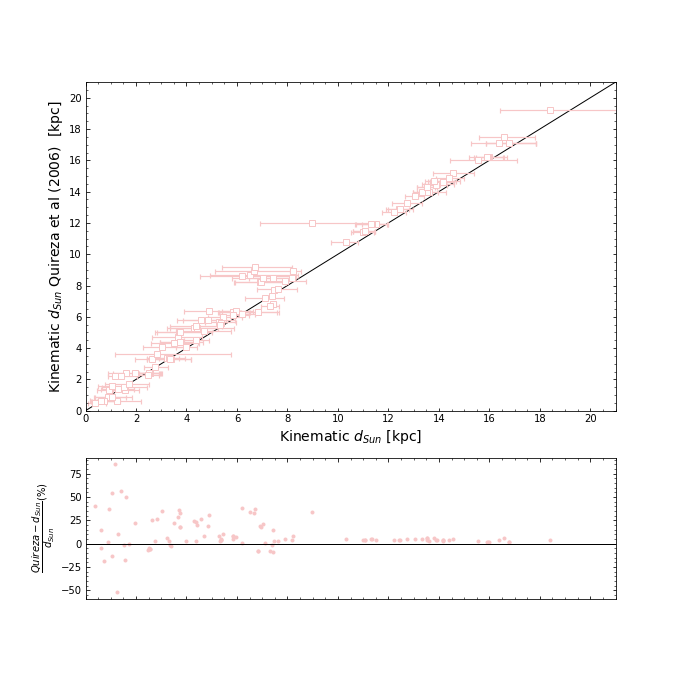

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Custom soft pastel colors
black= 'k'
pastel_pink = '#f7c6c7'

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3.5, 1.5]})

# Soft pastel red line
ax[0].plot(np.linspace(0,21), 1*np.linspace(0,21), linestyle = '-', c = black, zorder = 0, lw = 1) #Linea Recta

# Errorbar points with soft pastel pink
ax[0].errorbar(df_Quireza['dSun_new'], df_Quireza['dSun'],xerr=[Quireza3['em_d'], Quireza3['ep_d']],
                fmt='s',capsize=2.5,capthick=1.2, elinewidth=1.2, mec=pastel_pink, mfc= 'white',
               ecolor=pastel_pink, alpha=1, zorder=1)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax[0].set_xticks(np.arange(0,22,2))
ax[0].set_yticks(np.arange(0,22,2))
ax[0].set_xlim(0,21)
ax[0].set_ylim(0,21)
ax[0].set_xlabel(r'Kinematic $d_{Sun}$ [kpc]', size=14)
ax[0].set_ylabel(r'Kinematic $d_{Sun}$ Quireza et al (2006)  [kpc]', size=14)

# Scatter points with soft pastel pink
ax[1].scatter(df_Quireza['dSun_new'], porcentaje_dsun_quireza, c=pastel_pink, marker='.', zorder=0)

# Soft pastel red horizontal line
ax[1].axhline(y=0, color=black, linestyle='-', zorder=1, lw=1)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax[1].set_xticks(np.arange(0,21,2))
ax[1].set_xlim(0,21)
#ax[1].set_yticks(np.arange(-50,76,25))
#ax[1].set_ylim(-50,100)
ax[1].set_xticklabels([])
ax[1].set_ylabel('$\dfrac{Quireza - d_{Sun}}{d_{Sun}}$(%)')

plt.show()
plt.savefig('dSun_Quireza_Comparation', dpi=300)

## NOTE: 
- Heliocentric distance from Wenger and Khan are estimate just to see their behavior. For the Temperature Gradient we'll use their heliocentric distance and uncertainties to estimate the our galactocentric radius and uncertainties

### Wenger 2019:

To Wenger 2019. For this data we'll be careful:

Wenger used the VLA Telescope

In table 1 they present 148 principal regions where we have RA and DEC.Those 148 regions where 114 presented radio continuum emission where the physical parametres are in table 4. From those 114 regions, 82 regions presented RRL, we'll use those 82 regions in our study, in the table 5 are the physical parametres from those regions: $V^{P}_{LSR}$, $V^{T}_{LSR}$ with their uncertainties with the name of each nebula. In table 6 does a mix of data with another paper called "Azimuthal Metallicity Structure in the Milky Way Disk" getting a total of 198 regions, which 46 distances to those regions are determinated by parallax, their reference is in the same table. Then we have 143 regions where we have a lot of NaNs values therefore we have total of 120 regions with Kinematic Distance. In “Azimuthal Metallicity Structure in the Milky Way Disk” tabla 3 present many regiones (221) with their physical parametres as “Te where those data are taken  with 140 Foot Telescope and GBT. Therefoce tabla 6 is a mix from those telescopes: VLA, 140 Foot y GBT.With the 140 Foot we have: 14 regiones, with the GBT we have: 51, with the VLA we have: 55, with the last one 55 regions we'll determinate their heliocentric distances since these are the ones that present our paper.

In [15]:
### IMPORT THE 3 TABLES FROM WENGER:
VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/887/114/table1" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Wenger = tab.to_pandas()



VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/887/114/table5" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Wenger2 = tab.to_pandas()

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/887/114/table6" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Wenger3 = tab.to_pandas()


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [16]:
#Select the columns we are going to work from Wenger:

Wenger = Wenger[['Name', 'RAJ2000', 'DEJ2000']]

Wenger2 = Wenger2[['Name', 'VlsrP', 'e_VlsrP', 'VlsrT', 'e_VlsrT']]

Wenger3 = Wenger3[['Name', 'Tel', 'Dist', 'e_Dist', 'E_Dist', 'Rad', 'e_Rad', 'E_Rad','Meth', 'Te', 'e_Te']]

In [17]:
##We're going to clean our table:

#Filter with the Kinematic distances:

Wenger_K = Wenger3[Wenger3['Meth'] == 'K']

#Apply mask:
mask = ~np.isnan(Wenger3['Dist'])

Wenger_K = Wenger_K[mask]

print(len(Wenger_K))

120


<ipython-input-17-445c119efb88>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Wenger_K = Wenger_K[mask]


In [18]:
###Just for curiosity see how many data are in the other telescopes:

Foot = Wenger_K[Wenger_K['Tel'] == '140 Foot']
print('Los datos presentes con el telescopio 140 Foot son:',  len(Foot))

VLA = Wenger_K[Wenger_K['Tel'] == 'VLA']
print('Los datos presentes con el telescopio VLA son:', len(VLA), '(Con estos vamos a trabajar)')

GBT = Wenger_K[Wenger_K['Tel'] == 'GBT']
print('Los datos presentes con el telescopio GBT son:', len(GBT))

Los datos presentes con el telescopio 140 Foot son: 14
Los datos presentes con el telescopio VLA son: 55 (Con estos vamos a trabajar)
Los datos presentes con el telescopio GBT son: 51


In [19]:
###Merge:

#First marge:

merged_df1 = Wenger.merge(Wenger2, on='Name')
merged_df1 #55

#Second marge:

merged_df2 = merged_df1.merge(Wenger_K, on = 'Name')

common_names = set(Wenger["Name"]) & set(Wenger2["Name"] ) & set(Wenger_K['Name']) 
print(len(common_names))

#Apply a mask over  V_lsrt

mask2 = ~np.isnan(merged_df2['VlsrT'])

merged_df2 = merged_df2[mask2]

43


In [20]:
#Calculate glong

l = np.array([])
coord_l = SkyCoord(merged_df2['RAJ2000']*u.degree, merged_df2['DEJ2000']*u.degree).galactic.l.value
l = np.append(l, coord_l)

#Calculate glat

b = np.asarray([]) 
coord_b = SkyCoord(merged_df2['RAJ2000']*u.degree, merged_df2['DEJ2000']*u.degree).galactic.b.value
b = np.append(b, coord_b)
    
merged_df2['GLON'], merged_df2['GLAT'] = l, b

## Velocidades y errores:

merged_df2['Vrev'] = VrevLSR(merged_df2['VlsrT'], l, b )
merged_df2['e_Vrev'] = e_VrevLSR(merged_df2['e_VlsrT'], l , b)
merged_df2 = merged_df2.drop(['VlsrP', 'e_VlsrP'], axis=1)

In [21]:
with Pool(processes=15) as pool:
    d2 = _rotcurve_kd_worker(2500, l, merged_df2['Vrev'], merged_df2['e_Vrev'], pool = pool)

In [22]:
merged_df2['near'], merged_df2['e_near'], merged_df2['E_near'], merged_df2['far'], merged_df2['e_far'], merged_df2['E_far'], merged_df2['tan'], merged_df2['e_tan'], merged_df2['E_tan'] = d2['d_near'], d2['em_d_near'], d2['ep_d_near'], d2['d_far'], d2['em_d_far'], d2['ep_d_far'], d2['d_tan'], d2['em_d_tan'], d2['ep_d_tan']


#Now We're gonna applied the closest_distance_with_nan function to Quireza3 and see the 50 first results:

merged_df2[['d_SunNew', 'em_d', 'ep_d']] = merged_df2.apply(lambda row: closest_distance_with_nan_and_threshold(row, 'Dist'), axis=1)
merged_df2 = merged_df2.drop(['near', 'e_near', 'E_near', 'far', 'e_far', 'E_far', 'tan', 'e_tan', 'E_tan'], axis = 1)
merged_df2 = merged_df2.reset_index(drop = True)
merged_df2

,Name,RAJ2000,DEJ2000,VlsrT,e_VlsrT,Tel,Dist,e_Dist,E_Dist,Rad,...,Meth,Te,e_Te,GLON,GLAT,Vrev,e_Vrev,d_SunNew,em_d,ep_d
0,G017.928-00.677,276.507083,-13.637389,38.4,1.0,VLA,12.65,0.37,0.37,5.41,...,K,6269,877,17.927993,-0.676978,37.817918,4.448040,12.4560,0.46200,0.44816
1,G018.584+00.344,275.895417,-12.580194,14.3,0.9,VLA,14.36,0.39,0.42,7.02,...,K,5712,645,18.584067,0.343866,15.542995,2.471597,14.0350,0.43500,0.43900
2,G019.728-00.113,276.855000,-11.781972,52.9,0.9,VLA,11.89,0.43,0.36,4.89,...,K,5813,629,19.727906,-0.112850,52.544345,5.387880,11.6395,0.51166,0.44450
3,G020.363-00.014,277.067083,-11.173778,55.5,0.5,VLA,11.68,0.40,0.40,4.86,...,K,6150,367,20.362986,-0.013997,54.903117,6.807248,11.5270,0.57132,0.51216
4,G023.661-00.252,278.828750,-8.359500,67.2,0.4,VLA,10.98,0.44,0.41,4.76,...,K,5583,318,23.661027,-0.252029,67.352291,6.570930,10.7630,0.56800,0.50900
5,G025.397+00.033,279.378333,-6.685778,-14.0,0.2,VLA,16.40,0.47,0.66,9.53,...,K,7893,142,25.397882,0.033523,-13.611201,2.429210,16.1480,0.63000,0.69216
6,G025.398+00.562,278.905833,-6.442778,11.5,0.3,VLA,14.11,0.36,0.41,7.49,...,K,7610,177,25.397962,0.562094,12.787824,2.126418,13.7920,0.44116,0.44900
7,G027.562+00.084,280.330417,-4.739278,88.2,0.3,VLA,9.65,0.58,0.50,4.43,...,K,5765,261,27.562074,0.083840,87.591245,4.620748,9.4390,0.69600,0.57732
8,G028.320+01.243,279.645417,-3.534667,-39.6,4.5,VLA,19.42,0.98,1.15,12.63,...,K,14189,2932,28.320042,1.242906,-37.953250,4.613579,18.7515,1.09714,1.30566
9,G028.451+00.001,280.812083,-3.986389,-6.9,0.8,VLA,15.25,0.46,0.50,8.87,...,K,7576,629,28.451261,0.001099,-7.284504,2.207462,15.0370,0.56116,0.57748


In [23]:
porcentaje_dsun_wenger = porcentaje(merged_df2['d_SunNew'], merged_df2['Dist'])

<IPython.core.display.Javascript object>


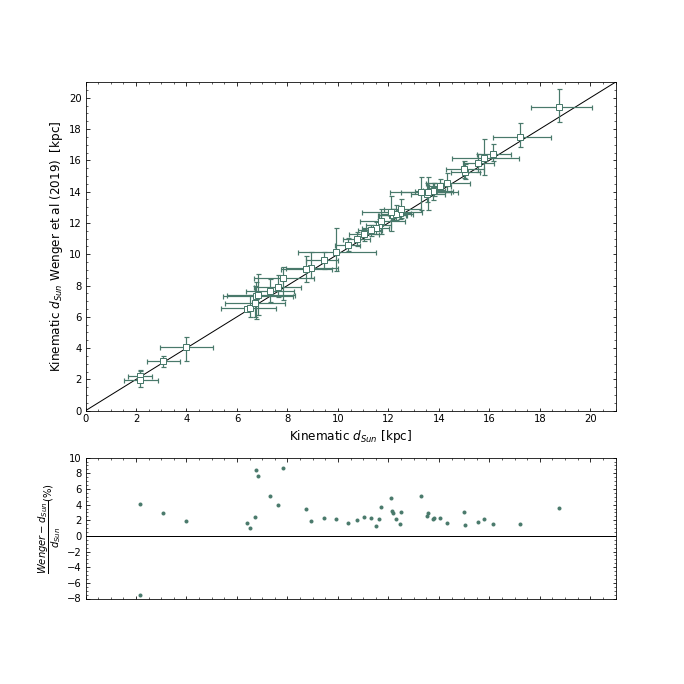

In [130]:
#Plot

dark_green = '#49796B'

fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3.5, 1.5]})

ax[0].plot(np.linspace(0,21), 1*np.linspace(0,21), c = 'k', linestyle = '-', zorder = 0, lw = 1) #Linea Recta

ax[0].errorbar(merged_df2['d_SunNew'], merged_df2['Dist'], xerr =[merged_df2['em_d'],  merged_df2['ep_d']], 
            yerr = [merged_df2['e_Dist'], merged_df2['E_Dist']],fmt = 's',capsize=2.5,capthick=1.2, elinewidth=1.2, 
               mec=dark_green, mfc= 'white', ecolor=dark_green, alpha=1, zorder=1)
ax[0].minorticks_on() #minorticks on
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True) #Parametres of ticks
ax[0].set_xticks(np.arange(0,21, 2)) #ticks two in two in x axis
ax[0].set_yticks(np.arange(0,21, 2)) #ticks two in two in y axis
ax[0].set_xlim(0,21)
ax[0].set_ylim(0,21)
ax[0].set_xlabel(r'Kinematic $d_{Sun}$ [kpc]', size = 12)
ax[0].set_ylabel(r'Kinematic $d_{Sun}$ Wenger et al (2019)  [kpc]', size = 12)

ax[1].scatter(merged_df2['d_SunNew'], porcentaje_dsun_wenger, c =dark_green, marker = '.', zorder = 0) #Data
ax[1].axhline(y=0, color=black, linestyle = '-', zorder = 1, lw = 1) #Red Line
ax[1].minorticks_on() #Minorticks on 
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True) #Parametres of ticks
ax[1].set_xticks(np.arange(0,21, 2)) #ticks two in two in x axis
ax[1].set_xlim(0,21)
ax[1].set_yticks(np.arange(-8, 12, 2))
ax[1].set_ylim(-8, 10)
ax[1].set_xticklabels([])  # Remove x-axis tick labels
ax[1].set_ylabel('$\dfrac{Wenger - d_{Sun}}{d_{Sun}}$(%)')
plt.savefig('Dsun_Wenger_Comparation', dpi = 300)

### Khan 2024:

Khan et al. (2024) has total of 244 regions, which the distances of 29 could't be calculated because they are very close to the galactic center (GC) $ -2 \le l \le 2 $, $ |b| \le 1 $ therefoce we have only 215 regions. From those 244 regions were compared with other studies to get a reliable distance, they got the distance from literature of 149 regions between $ 3 \le l \le 60$. From those 149 regions of the literauture we have: Regions with parallax distances: 28 (Reid et al. 2019), Regions with kinematic distances: 121 (Anderson & Bania 2009; Anderson et al. 2012; Urquhart et al. 2018). 13 Regions they adopted a distance of 1.4Kpc Cygnus X direction and the 53 remaining regions they determinated their Kinematic Distances.
Khan has two tables.

In [25]:
### Import the tables of Khan et al. (2024) and Reid et al. (2019)

#Khan:

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/A+A/689/A81/tablec1" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Khan = tab.to_pandas()

#Khan 2:

table2 = "J/A+A/689/A81/tablec2" # change the table

job2 = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table2}"
   """,
    output_format="csv",
)
tab2 = job2.get_results()
Khan2 = tab2.to_pandas()

#Reid:

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/885/131/table1" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Reid = tab.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [26]:
#Khan 1:
Khan = Khan[['Name', 'GLONpeak', 'GLATpeak', 'Vlsr', 'e_Vlsr', 'Dsun', 'e_Dsun', 'RGC', '_RA_icrs', '_DE_icrs']]

#Khan2
Khan2 = Khan2[['Name', 'Te', 'e_Te']]

#Mask:

mask3 =  ~np.isnan(Khan['Dsun'])

Khan = Khan[mask3]
Khan2 = Khan2[mask3]

#Merge both tables:

Khan = Khan.merge(Khan2, on = 'Name')

In [27]:
## New Velocities:
Khan['Vrev'] = VrevLSR(Khan['Vlsr'], Khan['GLONpeak'], Khan['GLATpeak'] )
Khan['e_Vrev'] = e_VrevLSR(Khan['e_Vlsr'], Khan['GLONpeak'] , Khan['GLATpeak'])

In [28]:
with Pool(processes=15) as pool:
    d3 = _rotcurve_kd_worker(2500, Khan['GLONpeak'], Khan['Vrev'], Khan['e_Vrev'], pool = pool)

In [29]:
#Assign our results, 'near', 'far' and 'tan' with their errors to the Khan DatFrame because is this Df
# We have our Dsun distance and we can see and compare the values.

Khan['near'], Khan['e_near'], Khan['E_near'], Khan['far'], Khan['e_far'], Khan['E_far'], Khan['tan'], Khan['e_tan'], Khan['E_tan'] = d3['d_near'], d3['em_d_near'], d3['ep_d_near'], d3['d_far'], d3['em_d_far'], d3['ep_d_far'], d3['d_tan'], d3['em_d_tan'], d3['ep_d_tan']


#Now We're gonna applied the closest_distance_with_nan function to Quireza3 and see the 50 first results:

Khan[['d_SunNew', 'em_d', 'ep_d']] = Khan.apply(lambda row: closest_distance_with_nan_and_threshold(row, 'Dsun'), axis=1)
Khan = Khan.drop(['near', 'e_near', 'E_near', 'far', 'e_far', 'E_far', 'tan', 'e_tan', 'E_tan'], axis = 1)

In [30]:
porcentaje_dsun_khan = porcentaje(Khan['d_SunNew'], Khan['Dsun'])

<IPython.core.display.Javascript object>


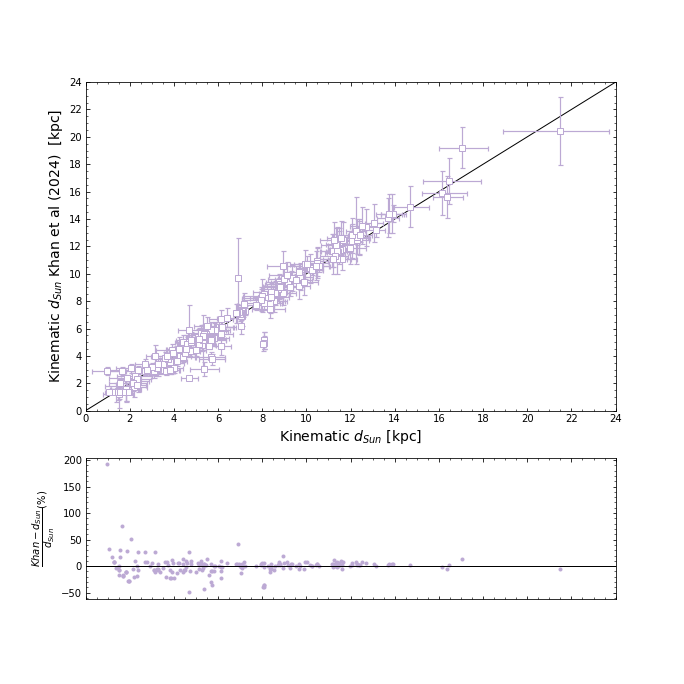

In [138]:
#Plot

purple = '#BCA9D4'
fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3.5, 1.5]})

ax[0].plot(np.linspace(0,24), 1*np.linspace(0,24), c = black, linestyle = '-', zorder = 0, lw = 1) #Linea Recta
ax[0].errorbar(Khan['d_SunNew'], Khan['Dsun'], xerr =[Khan['em_d'],  Khan['ep_d']], yerr = Khan['e_Dsun'],fmt = 's',
                capsize=2.5,capthick=1.2, elinewidth=1.2, mec=purple, mfc= 'white', ecolor=purple, 
               alpha=1, zorder=1)
ax[0].grid(False)
ax[0].minorticks_on() #minorticks on
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True) #Parametres of ticks
ax[0].set_xticks(np.arange(0,25, 2)) #ticks two in two in x axis
ax[0].set_yticks(np.arange(0,25, 2)) #ticks two in two in y axis
ax[0].set_xlim(0,24)
ax[0].set_ylim(0,24)
ax[0].set_xlabel(r'Kinematic $d_{Sun}$ [kpc]', size = 14)
ax[0].set_ylabel(r'Kinematic $d_{Sun}$ Khan et al (2024)  [kpc]', size = 14)

ax[1].scatter(Khan['d_SunNew'], porcentaje_dsun_khan, c =purple, marker = '.', zorder = 0) #Data
ax[1].axhline(y=0, color=black, linestyle = '-', zorder = 1, lw = 1) #Red Line
ax[1].minorticks_on() #Minorticks on 
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True) #Parametres of ticks
ax[1].set_xticks(np.arange(0,25, 2)) #ticks two in two in x axis
ax[1].set_xlim(0,24)
#ax[1].set_yticks(np.arange(-50, 101, 25))
#ax[1].set_ylim(-50, 100)
ax[1].set_xticklabels([])  # Remove x-axis tick labels
ax[1].set_ylabel('$\dfrac{Khan - d_{Sun}}{d_{Sun}}$(%)')

plt.savefig('Dsun_Khan_comparation', dpi = 300)

## Now we're gonna estimate $R_{Gal}$ 

We are going to define the functions that calculate our $R_{Gal}$ with their uncertainties using MonteCarlo:

In [32]:
# This function calculate R, use the coordinates and distance to the Galactic center as parametres

def R(RA,DEC, Dsun, GC):
    """
    We calculate the Galactocentric Radius using Right Ascension RA, Declination DEC, Heliocentric Distance and 
    Galactocentric Distance.
    
    Parametres: 
        RA: 1D array of the Right Ascension
        DEC: 1D array of the Declination
        Dsun: 1D array or Array of the Heliocentric Distance
        GC: 1D array of the Distance to the Galactic Center
    Return:
        R_C: Galactocentric Radius of an object
        
    """    
    GC_median = np.median(GC)
    GC_16 = np.percentile(GC, 16)
    GC_84 = np.percentile(GC, 84)
    
    rd = SkyCoord(ra = (RA)*u.degree, dec = (DEC)*u.degree, distance = (Dsun)*u.kpc , frame = 'icrs') #Coordenadas
    G_C_median = rd.transform_to(Galactocentric(galcen_distance = GC_median*u.kpc)) #Transformación
    G_C_16 = rd.transform_to(Galactocentric(galcen_distance = GC_16*u.kpc))
    G_C_84 = rd.transform_to(Galactocentric(galcen_distance = GC_84*u.kpc))
    
    R_C = np.sqrt( (G_C_median.x/3+G_C_16.x/3+G_C_84.x/3)**2 + (G_C_median.y/3+G_C_16.y/3+G_C_84.y/3)**2 + \
                 (G_C_median.z/3+G_C_16.z/3+G_C_84.z/3)**2  )
    
    return R_C

#This function estimate the uncertainties in the Rgal distances using the uncertainties in the heliocentric distances,  
#Helio (e_Dist), (E_Dist) and the uncertainties in the GC distance, return a upper and lower uncertanties.

def e_Rgal(RA, DEC, Dist, e_Dist, E_Dist):
    """
    We calculate the errors in the Galactocentric Radius of an object using a MonteCarlo Simulation.
    Parametres:
        RA: 1D Array of the Right Ascension
        DEC: 1D Array of the Declination
        Dist: 1D Array of the Heliocentric Distance
        e_Dist: 1D Array of the lower uncertainties in the Heliocentric Distance
        E_Dist: 1D Array of the upper uncertainties in the Heliocentric Distance
        
    Return:
        e_Rm_list2: 1D array of the lower uncertainties in the galactocentric radius
        e_Rp_list2: 1D array of the uppper uncertainties in the galactocentric radius
    """  
    GC = 8.2 # Galactic Center (GC)
    e_GC = 0.1 #Uncetainty in GC
    n_samples = 10000 #Sample number of MonteCarlo
    e_Distance = (e_Dist + E_Dist)/2 #MEAN of the Uncertainties in the Distance using the upper and lower uncertaties.
    
    #Empty lists:

    e_Rm_list2 = [] 
    e_Rp_list2 = [] 

    #Monte Carlo Simulation for each row in the dataframe:
    
    for i in range(len(Dist)):         
        
        #MonteCarlo Simulation for the heliocentric distance:
        Dsun_samples = np.absolute(np.random.normal(Dist[i], e_Distance[i], n_samples))
        
        #MonteCarlo Simulation for the distance to the GC:
        GC_samples = np.random.normal(GC, e_GC, n_samples)     
    
        #Sample of the GC radiues:
    
        RGC_samples = R(RA[i], DEC[i], Dsun_samples, GC_samples).value 
        
        peak_R = np.median(RGC_samples)
        
        
        #Percentiles 16th y 84th
        R_16th = np.percentile(RGC_samples, 16)
        R_84th = np.percentile(RGC_samples, 84)
    
        #Uncertainties:
        R_m = np.median(RGC_samples)
        e_Rm = R_m - R_16th
        e_Rp = R_84th - R_m
    
        #Concatenate:
    
        e_Rm_list2 = np.append(e_Rm_list2, np.absolute(e_Rm))
        e_Rp_list2 = np.append(e_Rp_list2, np.absolute(e_Rp))
    
    return e_Rm_list2, e_Rp_list2

### Quireza:

In [33]:
##Two nebulae, G49.582-0.38 (1851K,6.5 kpc) and G5.956-1.265 (3416 K, 7.8 kpc) have temperaturesmuch lower than the 7585 -1262 K
#average Te for the 6-8 kpc interval of RGal. Moreover, the G49.582-0.38 temperature is -3600Klower than theWWB83 value. 
#For these sources, we had to use TP continuummeasurements to derive Te . This mayhave compromised the accuracy of our result.
#G5.899-0.427 (11,128 K, 6.1 kpc) also lies far from the general trend of the sample

print('Estos son los index donde el error es mayor a 4000 en Te:', df_Quireza.index[df_Quireza['e_Te'] > 4000].tolist()) #Error en la temperatura mayor a 4000
print('Estos son los index donde la temperatura es mayor a 20,000K:', df_Quireza.index[df_Quireza['Te'] > 20000].tolist()) #Te > 20000
print('Estos son los index para las regiones G49.582-0.38, G5.956-1.265 y G5.899-0.427:', df_Quireza.index[(df_Quireza['Name'] == 'G49.582-0.38') | (df_Quireza['Name'] =='G5.956-1.265') | (df_Quireza['Name'] == 'G5.899-0.427')].tolist())

# Remove 5 data of our dataframe:

df_Quireza2 = df_Quireza.drop([5,6,55,65,86])
print(len(df_Quireza2))

Estos son los index donde el error es mayor a 4000 en Te: [65, 86]
Estos son los index donde la temperatura es mayor a 20,000K: [86]
Estos son los index para las regiones G49.582-0.38, G5.956-1.265 y G5.899-0.427: [5, 6, 55]
114


In [34]:
#Mask: Remove NaN's values
mask2 = ~np.isnan(df_Quireza2['dSun_new'])

df_Quireza2 = df_Quireza2[mask2]


#Reset index:
df_Quireza2 = df_Quireza2.reset_index(drop = True)

#Calculate Rgal:

R_Quireza = R(df_Quireza2['_RA'], df_Quireza2['_DE'], df_Quireza2['dSun_new'], GC = 8.2) #Quireza
df_Quireza2['Rgal'] = R_Quireza

#Calculate glong
l = np.array([])
coord_l = SkyCoord(df_Quireza2['_RA']*u.degree, df_Quireza2['_DE']*u.degree).galactic.l.value
l = np.append(l, coord_l)

#Calculate glat
b = np.asarray([]) 
coord_b = SkyCoord(df_Quireza2['_RA']*u.degree, df_Quireza2['_DE']*u.degree).galactic.b.value
b = np.append(b, coord_b)

    
df_Quireza2['l'], df_Quireza2['b'] = l, b

In [35]:
#Calculate uncertainties:

e_RgalQuireza = e_Rgal(df_Quireza2['_RA'], df_Quireza2['_DE'], df_Quireza2['dSun_new'], df_Quireza2['em_d'],\
                       df_Quireza2['ep_d'])

[df_Quireza2['e_Rm'], df_Quireza2['e_Rp']] = e_RgalQuireza[0], e_RgalQuireza[1]


In [68]:
porcentaje_quireza = porcentaje(df_Quireza2['Rgal'], df_Quireza2['RGal'])

<IPython.core.display.Javascript object>


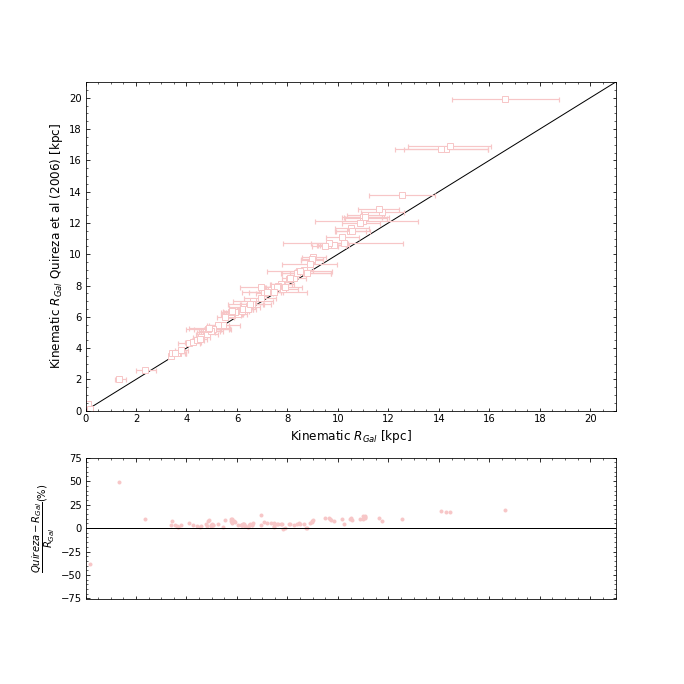

In [141]:
#Plot:

fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3.5, 1.5]})

ax[0].plot(np.linspace(0,21), 1*np.linspace(0,21), c = black, zorder = 0, lw = 1) #Red Line

ax[0].errorbar(df_Quireza2['Rgal'], df_Quireza2['RGal'], xerr = [df_Quireza2['e_Rm'], df_Quireza2['e_Rp']], fmt = 's', 
               capsize=2.5,capthick=1.2, elinewidth=1.2, mec=pastel_pink, mfc= 'white',
               ecolor=pastel_pink, alpha=1, zorder=1)

ax[0].minorticks_on() #minorticks on
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True) #Parametres of ticks
ax[0].set_xticks(np.arange(0,21, 2)) #ticks two in two in x axis
ax[0].set_yticks(np.arange(0,21, 2)) #ticks two in two in y axis
ax[0].set_xlim(0,21)
ax[0].set_ylim(0,21)
ax[0].set_ylabel(r'Kinematic $R_{Gal}$ Quireza et al (2006) [kpc]', size = 12)
ax[0].set_xlabel(r'Kinematic $R_{Gal}$ [kpc]', size = 12)


ax[1].scatter(df_Quireza2['Rgal'], porcentaje_quireza, c =pastel_pink, marker = '.', zorder = 0) #Data
ax[1].axhline(y=0, color=black, linestyle = '-', zorder = 1, lw = 1) #Red Line
ax[1].minorticks_on() #Minorticks on 
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True) #Parametres of ticks
ax[1].set_xticks(np.arange(0,21, 2)) #ticks two in two in x axis
ax[1].set_yticks(np.arange(0,21, 2)) #ticks two in two in y axis
ax[1].set_xlim(0,21)
ax[1].set_yticks(np.arange(-75, 76, 25))
ax[1].set_ylim(-75, 75)
ax[1].set_xticklabels([])  # Remove x-axis tick labels
ax[1].set_ylabel('$\dfrac{Quireza - R_{Gal}}{R_{Gal}}$(%)')
plt.show()
plt.savefig('Rgal_Quireza_Comparation', dpi = 300)

<IPython.core.display.Javascript object>


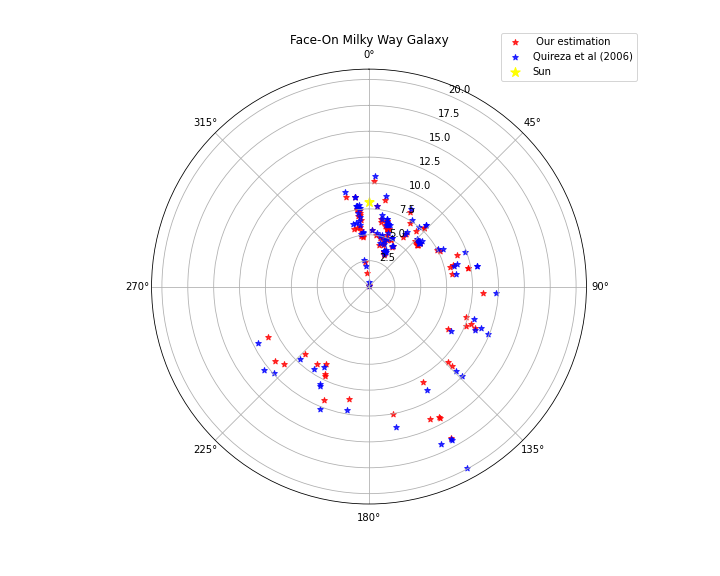

In [100]:
## Polar Plot:

# Create a polar plot
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': 'polar'})

r_1 = df_Quireza2['Rgal']
r_2 = df_Quireza2['RGal']
theta = np.deg2rad(df_Quireza2['l'])  # Adjust theta from the center
ax.scatter(theta, r_1, color='red', marker = '*' ,alpha = 0.8, label=' Our estimation')
ax.scatter(theta, r_2, color = 'blue', marker = '*', alpha = 0.8, label = 'Quireza et al (2006)')
ax.scatter(0, 8.2, s = 100, marker = '*', color = 'yellow', label = 'Sun')


# Set title and labels
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_rlim(0,21)
ax.set_title("Face-On Milky Way Galaxy")
angle = np.deg2rad(67.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(.6 + np.cos(angle)/2, .5 + np.sin(angle)/2))


plt.show()
plt.savefig('Face-On_Quireza', dpi = 300)

### Wenger:

For this case we are going to use two samples:

1) 43 regions with the VLA 

2) Total regions (166) repoteed in the paper

#### First sample: With this sample we're going to the determinate how good are our estimation of $R_{Gal}$ 

In [39]:
R_Wenger = R(merged_df2['RAJ2000'].values, merged_df2['DEJ2000'].values, merged_df2['d_SunNew'].values, GC = 8.2)
merged_df2['Rgal'] = R_Wenger

In [40]:
#Uncertainties:
e_RgalWenger = e_Rgal(merged_df2['RAJ2000'], merged_df2['DEJ2000'], merged_df2['d_SunNew'], merged_df2['em_d'], merged_df2['ep_d'])
[merged_df2['e_Rm'], merged_df2['e_Rp']] = e_RgalWenger[0], e_RgalWenger[1]

In [41]:
porcentaje_wenger = porcentaje(merged_df2['Rgal'], merged_df2['Rad'])

<IPython.core.display.Javascript object>


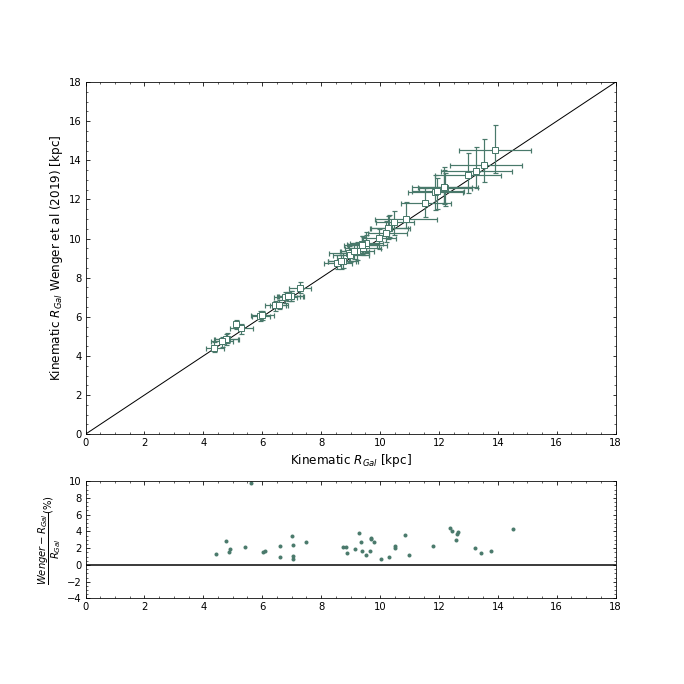

In [142]:
#Plot:

fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(np.linspace(0,18), 1*np.linspace(0,18), c = black, zorder = 0, lw = 1) #Linea Recta 
ax[0].errorbar(merged_df2['Rgal'], merged_df2['Rad'], xerr = [merged_df2['e_Rm'], merged_df2['e_Rp']], 
            yerr = [merged_df2['e_Rad'],merged_df2['E_Rad']], fmt = 's',capsize=2.5,capthick=1.2, elinewidth=1.2, 
               mec=dark_green, mfc= 'white', ecolor=dark_green, alpha=1, zorder=1)
ax[0].grid(False)
ax[0].minorticks_on()
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[0].set_xticks(np.arange(0,19, 2))
ax[0].set_yticks(np.arange(0,19, 2))
ax[0].set_xlim(0,18)
ax[0].set_ylim(0,18)
ax[0].set_xlabel(r'Kinematic $R_{Gal}$ [kpc]', size = 12)
ax[0].set_ylabel(r'Kinematic $R_{Gal}$ Wenger et al (2019) [kpc]', size = 12) 

ax[1].scatter(merged_df2['Rad'], porcentaje_wenger, c =dark_green, marker = '.', zorder = 0)
ax[1].axhline(y=0, color=black, linestyle = '-', zorder = 1)
ax[1].minorticks_on()
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[1].set_xticks(np.arange(0,19, 2))
ax[1].set_xlim(0,18)
ax[1].set_yticks(np.arange(-4, 11, 2))
ax[1].set_ylim(-4, 10)
#ax[1].set_xticklabels([])  # Remove x-axis tick labels
ax[1].set_ylabel('$\dfrac{Wenger - R_{Gal}}{R_{Gal}}$(%)')
plt.show()
plt.savefig('Rgal_Wenger1_Comparation', dpi = 300)

<IPython.core.display.Javascript object>


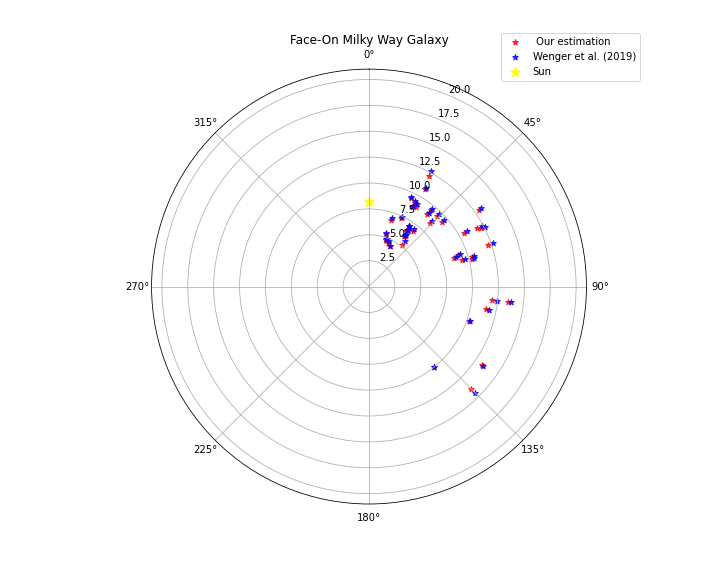

In [104]:
## Polar Plot:

# Create a polar plot
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': 'polar'})

r_1 = merged_df2['Rgal']
r_2 = merged_df2['Rad']
theta = np.deg2rad(merged_df2['GLON'])  # Adjust theta from the center
ax.scatter(theta, r_1, color='red', marker = '*', alpha = 0.8, label=' Our estimation')
ax.scatter(theta, r_2, color = 'blue', marker = '*', alpha = 0.8, label = 'Wenger et al. (2019)')
ax.scatter(0, 8.2, s = 100, marker = '*', color = 'yellow', label = 'Sun')


# Set title and labels
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_rlim(0,21)
ax.set_title("Face-On Milky Way Galaxy")
angle = np.deg2rad(67.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(.6 + np.cos(angle)/2, .5 + np.sin(angle)/2))


plt.show()
plt.savefig('Face-On_Wenger1', dpi = 300)

#### Second sample: With this one we're going to make the gradient

In [44]:
VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/887/114/table6" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Wenger3 = tab.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [45]:
#Mask:

mask3 =  ~np.isnan(Wenger3['Dist'])

Wenger3 = Wenger3[mask3]
#Wenger3[(Wenger3['e_Rad'] == 0) & (Wenger3['E_Rad'] == 0) ]
#Wenger3

In [46]:
#Calculate Rgal:

R_Wenger_Total = R(Wenger3['_RA'].values, Wenger3['_DE'].values, Wenger3['Dist'].values, GC = 8.2)  #Quireza
Wenger3['Rgal'] = R_Wenger_Total

Wenger3 = Wenger3.reset_index(drop = True)

#Calculate glong
l = np.array([])
coord_l = SkyCoord(Wenger3['_RA']*u.degree, Wenger3['_DE']*u.degree).galactic.l.value
l = np.append(l, coord_l)

#Calculate glat
b = np.asarray([]) 
coord_b = SkyCoord(Wenger3['_RA']*u.degree, Wenger3['_DE']*u.degree).galactic.b.value
b = np.append(b, coord_b)

    
Wenger3['l'], Wenger3['b'] = l, b

In [47]:
#Estimate uncertanties:

e_RgalWenger2 = e_Rgal(Wenger3['_RA'], Wenger3['_DE'], Wenger3['Dist'], Wenger3['e_Dist'], Wenger3['E_Dist'])
[Wenger3['e_Rm'], Wenger3['e_Rp']] = e_RgalWenger2[0], e_RgalWenger2[1]

In [48]:
porcentaje_wenger2 = porcentaje(Wenger3['Rgal'], Wenger3['Rad'])

<IPython.core.display.Javascript object>


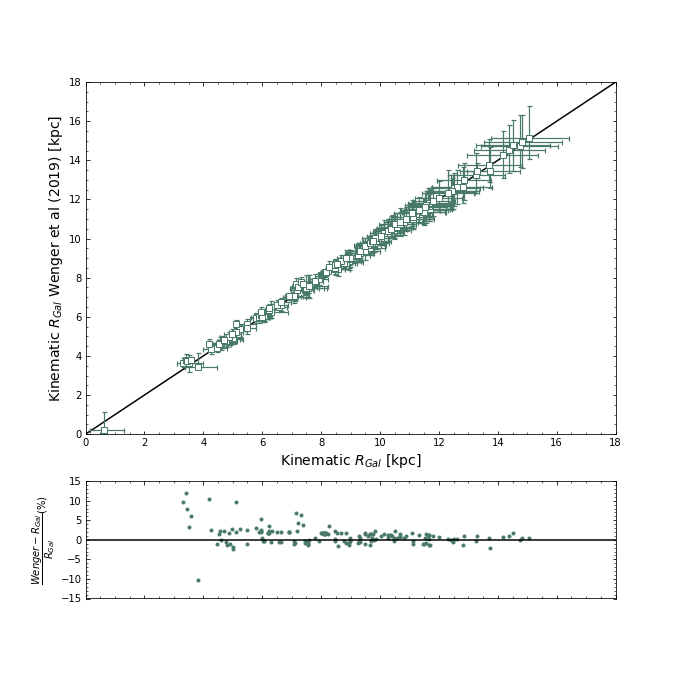

In [143]:
#Graficar:

fig, ax = plt.subplots(2, 1, figsize=(9.5,9.5), sharex=False, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(np.linspace(0,21), 1*np.linspace(0,21), c = black, linestyle = '-', zorder = 0) #Red line 
ax[0].errorbar(Wenger3['Rgal'], Wenger3['Rad'], xerr = [Wenger3['e_Rm'], Wenger3['e_Rp']],
            yerr = [Wenger3['e_Rad'], Wenger3['E_Rad']],fmt = 's', capsize=2.5,capthick=1.2, elinewidth=1.2, 
               mec=dark_green, mfc= 'white', ecolor=dark_green, alpha=1, zorder=1)
ax[0].grid(False)
ax[0].minorticks_on()
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[0].set_xticks(np.arange(0,19, 2))
ax[0].set_yticks(np.arange(0,19, 2))
ax[0].set_xlim(0,18)
ax[0].set_ylim(0,18)
ax[0].set_xlabel(r'Kinematic $R_{Gal}$ [kpc]', size = 14)
ax[0].set_ylabel(r'Kinematic $R_{Gal}$ Wenger et al (2019) [kpc]', size = 14)

ax[1].scatter(Wenger3['Rgal'], porcentaje_wenger2, c =dark_green, marker = '.', zorder = 0)
ax[1].axhline(y=0, color=black, linestyle = '-', zorder = 1)
ax[1].minorticks_on()
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[1].set_xticks(np.arange(0,19, 2))
ax[1].set_xlim(0,18)
ax[1].set_ylim(-15,15)
ax[1].set_yticks(np.arange(-15, 16, 5))
ax[1].set_xticklabels([])  # Remove x-axis tick labels
ax[1].set_ylabel('$\dfrac{Wenger - R_{Gal}}{R_{Gal}}$(%)')
plt.show()
plt.savefig('Rgal_Wenger2_Comparation', dpi = 300)

<IPython.core.display.Javascript object>


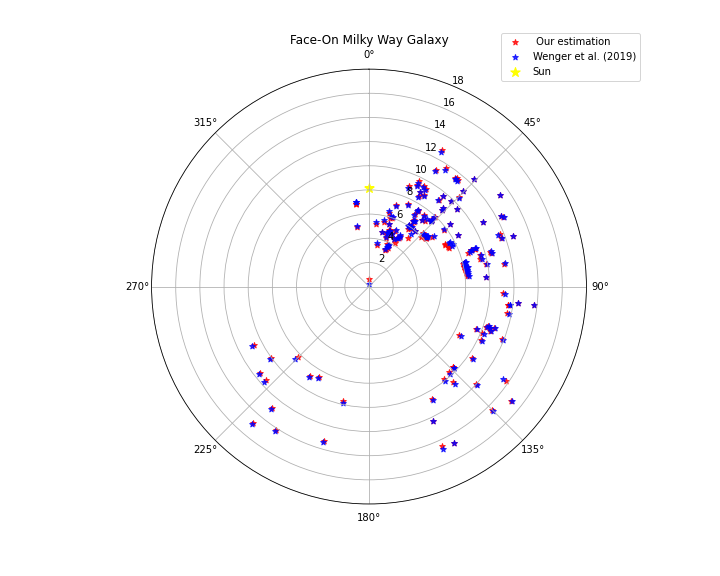

In [109]:
## Polar Plot:

#Calculate glong
l = np.array([])
coord_l = SkyCoord(Wenger3['_RA']*u.degree, Wenger3['_DE']*u.degree).galactic.l.value
l = np.append(l, coord_l)
Wenger3['GLON'] = l

# Create a polar plot
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': 'polar'})

r_1 = Wenger3['Rgal']
r_2 = Wenger3['Rad']
theta =  np.deg2rad(Wenger3['GLON']) # Adjust theta from the center
ax.scatter(theta, r_1, color='red', marker = '*', alpha = 0.8, label=' Our estimation')
ax.scatter(theta, r_2, color = 'blue', marker = '*', alpha = 0.8, label = 'Wenger et al. (2019)')
ax.scatter(0, 8.2, s = 100, marker = '*', color = 'yellow', label = 'Sun')


# Set title and labels
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_rlim(0,18)
ax.set_title("Face-On Milky Way Galaxy")
angle = np.deg2rad(67.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(.6 + np.cos(angle)/2, .5 + np.sin(angle)/2))

plt.show()
plt.savefig('Face-On_Wenger2', dpi = 300)

### Khan:

In [51]:
### We going to remove some data according to Khan that make noise, (anomalies)
##" two H II regions stand out as anomalies, deviating from the overall trend in Te, exhibiting significantly lower 
#temperatures: G025.479–0.174 (with a temperature of 1010 K and located at a distance of 4.95 kpc) and G030.870–0.099 
#(with a temperature of 1441 K and located at a distance of 4.85 kpc)."

print('Estos son los index para las regiones G025.479–0.174 y G030.870–0.099:', Khan.index[(Khan['Name'] == 'G025.479-0.174') | (Khan['Name'] =='G030.870-0.099')].tolist())

Khan2 = Khan.drop([97,137])
#Khan2 = Khan.drop(Khan.index[(Khan['e_Dsun'] == 0)])
print(len(Khan2))

Estos son los index para las regiones G025.479–0.174 y G030.870–0.099: [97, 137]
213


In [52]:
#Mask
mask4 =  ~np.isnan(Khan2['Dsun'])
Khan2 = Khan2[mask4]

#Reset index:
Khan2 = Khan2.reset_index(drop = True)
#Calculate Rgal:

R_Khan = R(Khan2['_RA_icrs'].values, Khan2['_DE_icrs'].values, Khan2['Dsun'].values, GC  = 8.2)
Khan2['Rgal'] = R_Khan

In [53]:
# Function to determinate the uncertainties of Rgal Khan 

def e_R_Khan(RA, DEC, Dsun, e_Dsun):
    
    GC = 8.2 # Galactic Center (GC)
    e_GC = 0.1 # Uncertainty in the GC
    n_samples = 10000 # Sample Number MonteCarlo

    #Empthy List:

    e_Rm_list = [] 
    e_Rp_list = [] 
    
    # Check if input arrays have the same length
    if not (len(RA) == len(DEC) == len(Dsun) == len(e_Dsun)):
        raise ValueError("Input arrays must have the same length.")

    #MonteCarlo Simulation for each row in the Dataframe

    for i in range(len(Dsun)):
        
        #MonteCarlo Simulation for Heliocentric Distance:
        Dsun_samples = np.absolute(np.random.normal(Dsun[i], e_Dsun[i], n_samples))
        
        #MonteCarlo Simulation for the distance to the Galactic Center:
        GC_samples = np.random.normal(GC, e_GC, n_samples)    
    
        #Calculos el Radio Galactocentrico:
        #Llamamos a la función R para determinar el Radio Galactocentrico
        RGC_samples = R(RA[i], DEC[i], Dsun_samples, GC_samples).value 
        
        if i < 10:
            fig, ax = plt.subplots(figsize = (10,6))
            ax.hist(RGC_samples, bins = int(np.sqrt(len(RGC_samples))), density=False,facecolor='white',edgecolor='black',
                       lw=2, alpha=1)
            
        
        #peak_R = x_eva[np.argmax(pdf_values)] #Este nos dará el Valor Central de R
        peak_R = np.median(RGC_samples)
        
        #Calcular los percentiles 16th y 84th
        
        R_16th = np.percentile(RGC_samples, 16)
        R_84th = np.percentile(RGC_samples, 84)
    
        #Errores asimetricos:
        e_Rm = peak_R - R_16th
        e_Rp = R_84th - peak_R
    
        #Concatenar:
    
        e_Rm_list = np.append(e_Rm_list, np.absolute(e_Rm))
        e_Rp_list = np.append(e_Rp_list, np.absolute(e_Rp))
        
        #ANOTHER WAY TO DETERMINATE THE UNCERTAIENTIES:
        
        #x_eva = np.linspace(min(RGC_samples), max(RGC_samples), num = 1000) # Arreglo en R que será el x de nuestra KDE
        
        #Para Calcular PDF ajustamos KDE:
        #KDE_Dp = stats.gaussian_kde(RGC_samples) #KDE
        
        #pdf_values = KDE_Dp(x_eva)
             
        # Calculate the CDF using KDE
        
        #cdf_values = np.cumsum(pdf_values)
        #cdf_values /= cdf_values[-1]  # Normalize to [0, 1]
        
        # Find 16th and 84th percentiles (lower and upper bounds)
        
        #lower_bound = x_eva[np.searchsorted(cdf_values, 0.16)]
        #upper_bound = x_eva[np.searchsorted(cdf_values, 0.84)]
        
        #Errores asimetricos:
    
        #e_Rm = peak_R - lower_bound
        #e_Rp = upper_bound - peak_R
        
        
    return e_Rm_list, e_Rp_list

<IPython.core.display.Javascript object>


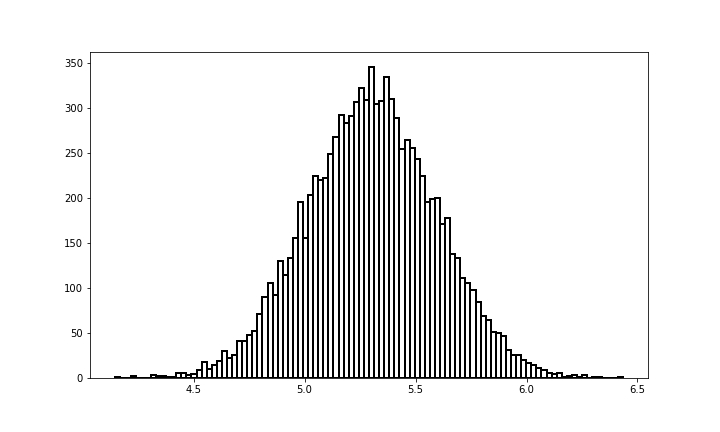

<IPython.core.display.Javascript object>


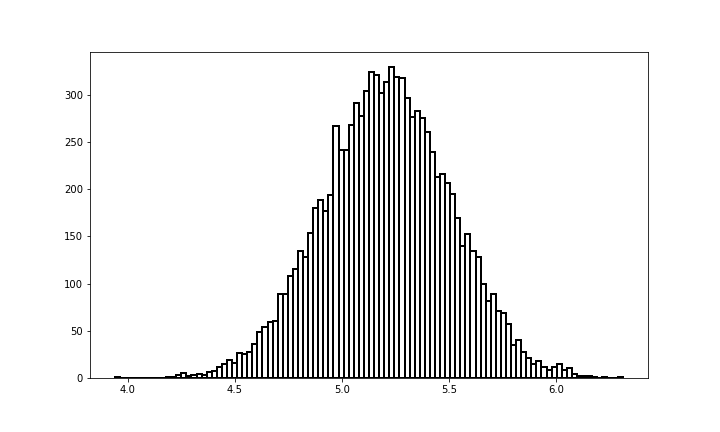

<IPython.core.display.Javascript object>


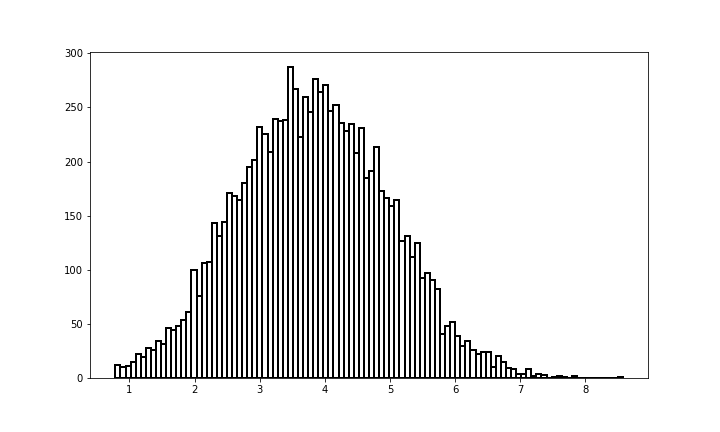

<IPython.core.display.Javascript object>


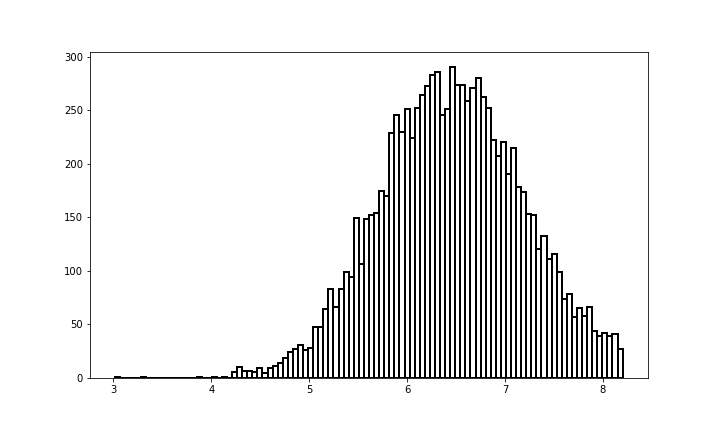

<IPython.core.display.Javascript object>


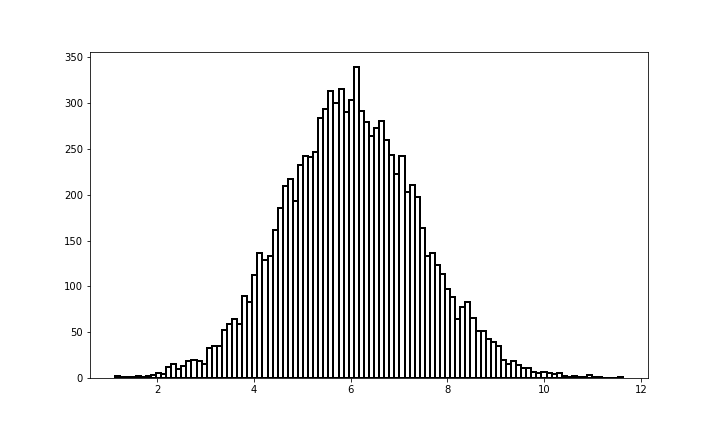

<IPython.core.display.Javascript object>


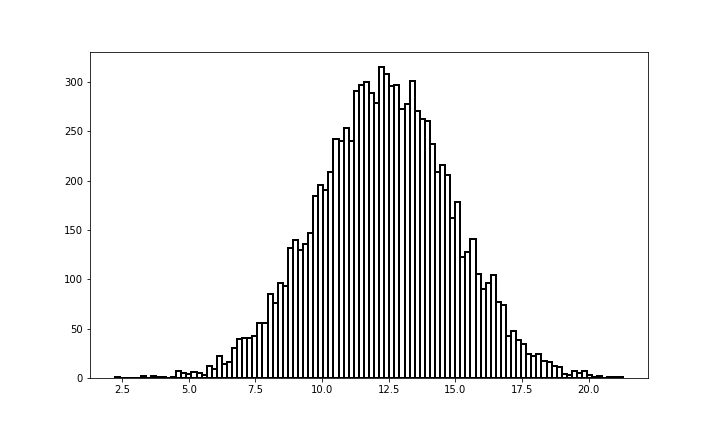

<IPython.core.display.Javascript object>


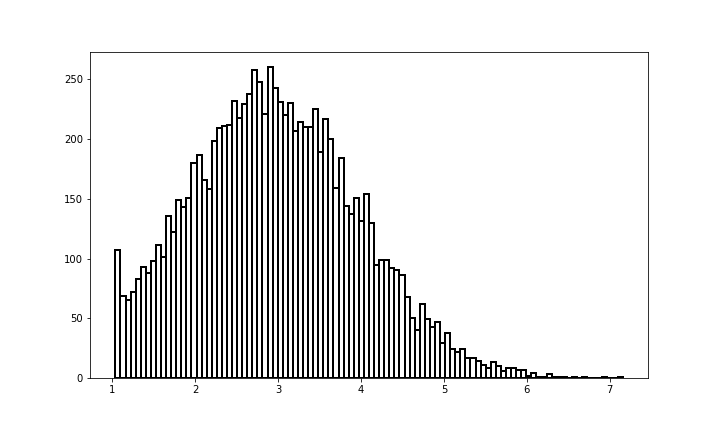

<IPython.core.display.Javascript object>


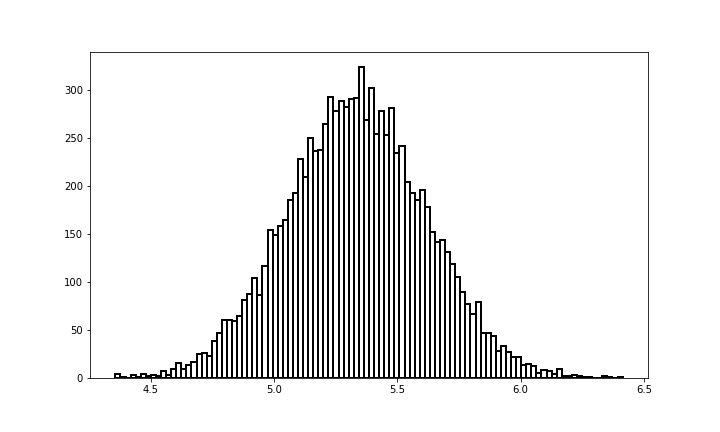

<IPython.core.display.Javascript object>


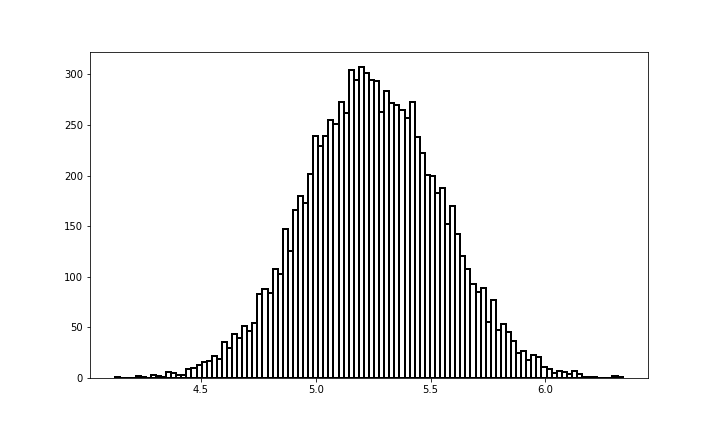

<IPython.core.display.Javascript object>


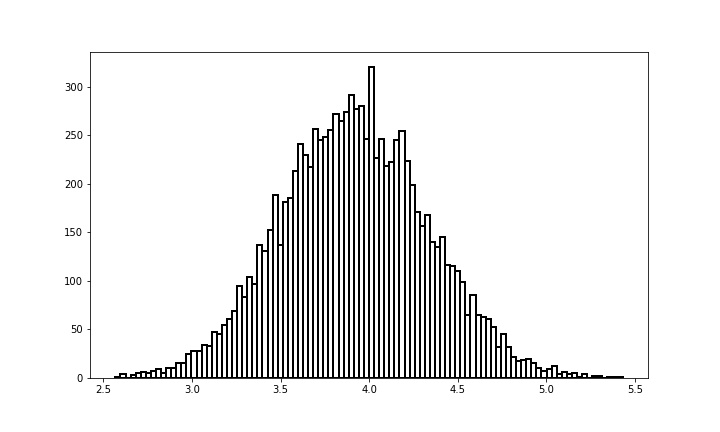

In [72]:
#Uncertainties:
e_RgalKhan = e_R_Khan(Khan2['_RA_icrs'], Khan2['_DE_icrs'], Khan2['Dsun'], Khan2['e_Dsun'])
[Khan2['e_Rm'], Khan2['e_Rp']] = e_RgalKhan[0], e_RgalKhan[1]

In [55]:
porcentaje_khan = porcentaje(Khan2['Rgal'], Khan2['RGC'])

<IPython.core.display.Javascript object>


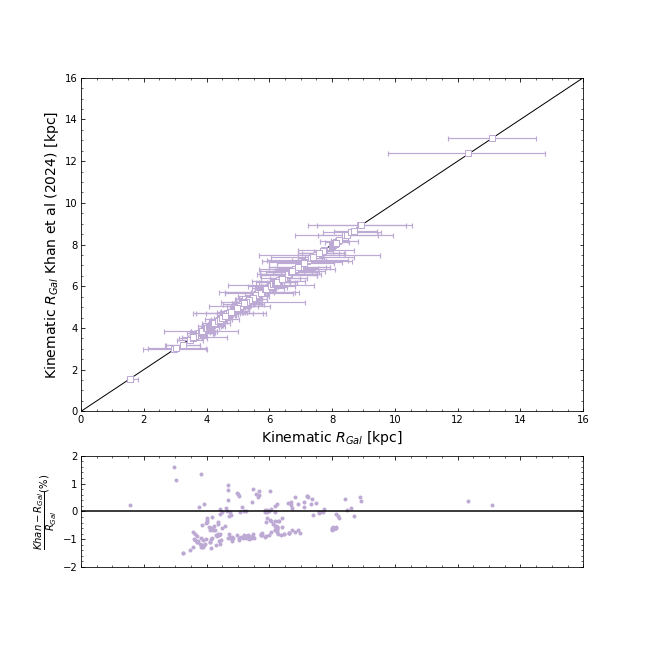

In [144]:
#Plot:
fig, ax = plt.subplots(2, 1, figsize=(9,9), sharex=False, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(np.linspace(0,16), 1*np.linspace(0,16), c = black, linestyle = '-', zorder = 0, lw = 1)

ax[0].errorbar(Khan2['Rgal'], Khan2['RGC'], xerr = [Khan2['e_Rm'], Khan2['e_Rp']], fmt = 's',
               capsize=2.5,capthick=1.2, elinewidth=1.2, mec=purple, mfc= 'white', ecolor=purple, 
               alpha=1, zorder=1)

ax[0].grid(False)
ax[0].minorticks_on()
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[0].set_xticks(np.arange(0,17, 2))
ax[0].set_yticks(np.arange(0,17, 2))
ax[0].set_xlim(0,16)
ax[0].set_ylim(0,16)
ax[0].set_ylabel(r'Kinematic $R_{Gal}$ Khan et al (2024) [kpc]', size =14)
ax[0].set_xlabel(r'Kinematic $R_{Gal}$ [kpc]', size = 14)

ax[1].scatter(Khan2['Rgal'], porcentaje_khan, c =purple, marker = '.', zorder = 0)
ax[1].axhline(y=0, color=black, linestyle = '-', zorder = 1)
ax[1].minorticks_on()
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[1].set_xticks(np.arange(0,17, 2))
ax[1].set_xlim(0,16)
ax[1].set_ylim(-2,2)
ax[1].set_xticklabels([])  # Remove x-axis tick labels
ax[1].set_ylabel('$\dfrac{Khan - R_{Gal}}{R_{Gal}}$(%)')
plt.show()
plt.savefig('Rgal_Khan_Comparation', dpi = 300)

<IPython.core.display.Javascript object>


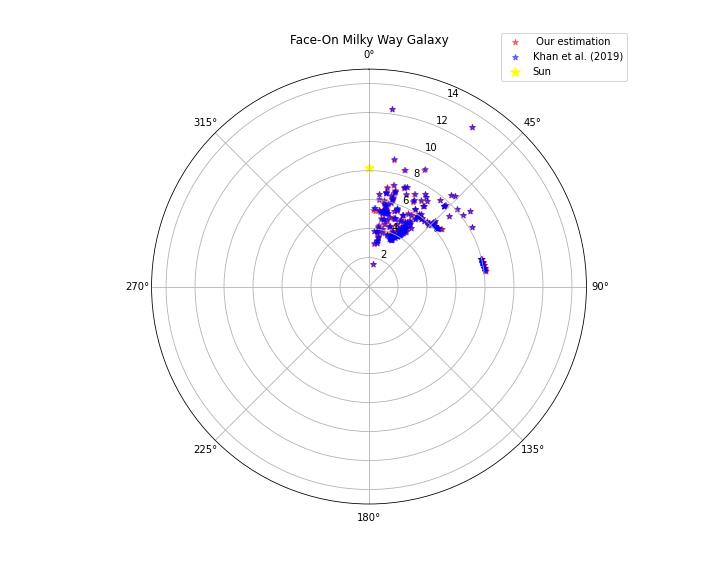

In [112]:
## Polar Plot:

# Create a polar plot
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': 'polar'})

r_1 = Khan2['Rgal']
r_2 = Khan2['RGC']
theta =  np.deg2rad(Khan2['GLONpeak']) # Adjust theta from the center
ax.scatter(theta, r_1, color='red', alpha = 0.5, marker = '*', label=' Our estimation')
ax.scatter(theta, r_2, color = 'blue', alpha = 0.5, marker = '*', label = 'Khan et al. (2019)')
ax.scatter(0, 8.2, s = 100, marker = '*', color = 'yellow', label = 'Sun')


# Set title and labels
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_rlim(0,15)
ax.set_title("Face-On Milky Way Galaxy")
angle = np.deg2rad(67.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(.6 + np.cos(angle)/2, .5 + np.sin(angle)/2))


plt.show()
plt.savefig('Face-On_Khan', dpi = 300)

## Temperature Gradient $T_e$ vs $R_{Gal}$ 

In [58]:
#A New Dataframe: df_new2 with all the information:

#Khan:

Data_Khan = {'Name': Khan2['Name'],'R_Gal': Khan2['Rgal'], 'e_Rm': Khan2['e_Rm'], 'e_Rp': Khan2['e_Rp'], 
             'Te': Khan2['Te']*10**3 , 'e_Te': Khan2['e_Te']*10**3}

df_Khan = pd.DataFrame(Data_Khan)
print('This is the total count of Khan: ', len(df_Khan))

#Wenger:

Data_Wenger = {'Name': Wenger3['Name'], 'R_Gal': Wenger3['Rgal'], 'e_Rm': Wenger3['e_Rm'], 'e_Rp': Wenger3['e_Rp'],
               'Te': Wenger3['Te'], 'e_Te': Wenger3['e_Te']}
df_Wenger = pd.DataFrame(Data_Wenger)
print('This is the total count of Wenger: ',len(df_Wenger))

#Quireza:

Data_Quireza2 = {'Name': df_Quireza2['Name'], 'R_Gal': df_Quireza2['Rgal'], 'e_Rm': df_Quireza2['e_Rm'], 
                 'e_Rp': df_Quireza2['e_Rp'], 'Te': df_Quireza2['Te'], 'e_Te': df_Quireza2['e_Te']}
df_Quireza3 = pd.DataFrame(Data_Quireza2)
print('This is the total count of Quireza: ', len(df_Quireza2))

#concatenate:

df_new2 = pd.concat([df_Khan, df_Wenger, df_Quireza3])
df_new2.reset_index(inplace = True, drop = True)
df_new2
print('This the total:',len(df_Wenger) + len(df_Khan) + len(df_Quireza3))

#mask5 = ~np.isnan(df_new2['Te'])

#df_new2 = df_new2[mask5]

This is the total count of Khan:  213
This is the total count of Wenger:  166
This is the total count of Quireza:  104
This the total: 483


In [59]:
#df_new2['e_Rm'], df_new2['e_Rp'] = 0.1, 0.1

"""""
El nuevo metodo de calculo en los errores en las distancias considera el error en R0 lo cual genera que algunas regiones
en Khan et al 2024 no sean 0 como con el viejo metodo modificando los errores del gradiente, y como Khan a dichas regiones
les asigno manuelmente los errores en las distancias heliocentricas a 0 no las vamos a considerar en nuestro estudio
por ende, las vamos a despreciar
"""""

df_new2 = df_new2[ (df_new2['e_Rm'] > 0) ]

#Reset index:

df_new2 = df_new2.reset_index(drop = True)
print(len(df_new2))
df_new2

468


,Name,R_Gal,e_Rm,e_Rp,Te,e_Te
0,G003.350-0.077,5.307665,0.286265,0.285813,6500.0,700.0
1,G004.417+0.125,5.214044,0.296684,0.296620,6600.0,1000.0
2,G005.475-0.244,3.818655,1.162452,1.130691,6800.0,800.0
3,G005.907-0.427,6.451950,0.733871,0.738646,7600.0,500.0
4,G006.552-0.095,6.026643,1.370023,1.378795,6700.0,400.0
...,...,...,...,...,...,...
463,G353.08+0.36,6.958763,0.850348,0.763933,5390.0,100.0
464,G353.14+0.66,7.484048,1.274491,1.271548,6250.0,30.0
465,G353.186+0.8,7.174938,0.688768,0.660386,7100.0,40.0
466,G353.398-0.3,4.845837,0.870037,0.855391,8480.0,60.0


<IPython.core.display.Javascript object>


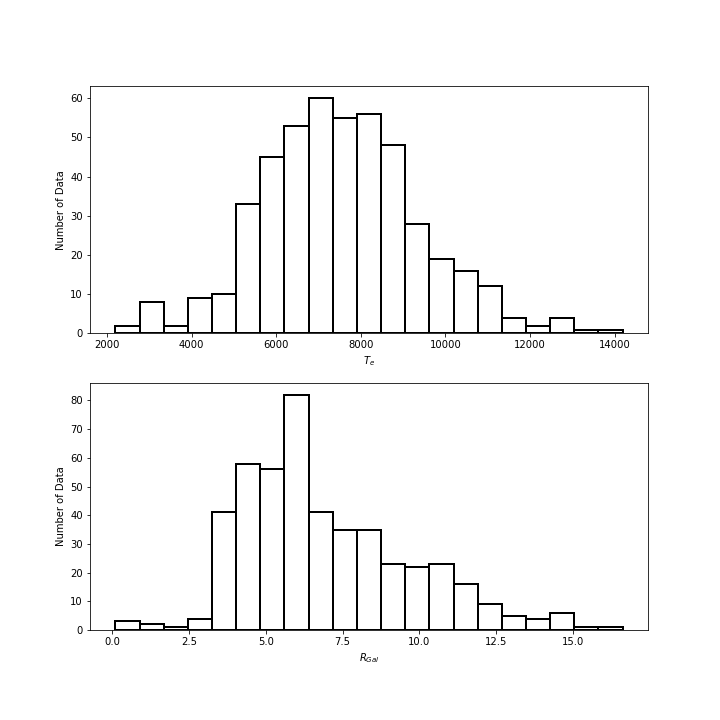

In [75]:
### See the distribution data:

fig, ax = plt.subplots(2,1,  figsize=(10,10))
bins = int(np.sqrt(len(df_new2['R_Gal'])))

ax[0].hist(df_new2['Te'], bins = bins, density=False,facecolor='white',edgecolor='black',lw=2, 
             alpha=1)
ax[0].set_xlabel('$T_e$')

ax[1].hist(df_new2['R_Gal'], bins = bins, density=False,facecolor='white',edgecolor='black',lw=2, 
             alpha=1 )
ax[1].set_xlabel('$R_{Gal}$')

for i in range(0,2):
    ax[i].set_ylabel(r'Number of Data')

In [61]:
def linfit(x, x_em, x_ep, y, y_e): #
    #Defimos el error en x como el valor medio:
    
    x_e = (x_em + x_ep)/2
      
    #definimos la forma de la funcion que queremos ajustar
            
    def func(p, x):
        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx = x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters, 1-sigma estimates & minimum chi-square
    popt = out.beta #Parametros 
    perr = out.sd_beta #Error
    chi_square_min = out.sum_square 
    
    v = len(x) - len(popt)  # Degrees of freedom (N - p, where p=2)

    # Reduced chi-square
    reduced_chi_square = chi_square_min/v


    c = popt[1]
    e_c = perr[1]
    
    m = popt[0]
    e_m = perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    return  c, e_c, m, e_m, chi_square_min, reduced_chi_square, correlation_coefficient

In [62]:
ORD = linfit(df_new2['R_Gal'], df_new2['e_Rm'].values, df_new2['e_Rp'].values, df_new2['Te'], df_new2['e_Te'])

print(ORD)

x = np.linspace(0, 20, len(df_new2['R_Gal']))
y = ORD[0] + ORD[2]*x

(4309.184818907191, 157.6975535096729, 529.1768504634298, 23.32967538939035, 15341.255625430143, 32.9211494107943, 0.5822941280315723)


In [63]:
linre = stats.linregress(df_new2['R_Gal'], df_new2['Te'])
y2 = linre[0]*x + linre[1]
print(linre)

LinregressResult(slope=397.5545338172932, intercept=4758.590590518473, rvalue=0.5822941280315721, pvalue=7.894922205139264e-44, stderr=25.71225935560408, intercept_stderr=192.3872269286395)


<IPython.core.display.Javascript object>


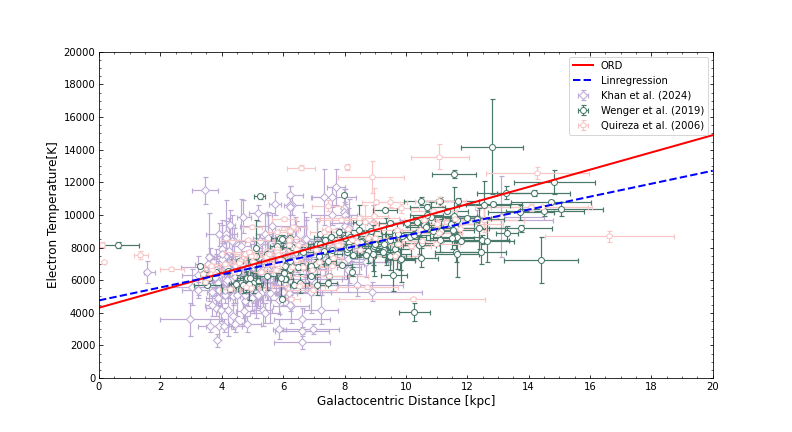

Slope ODR: 529.1769 ± 23.3297
Intercept ODR: 4309.1848 ± 157.6976
Slope Linregress:  397.5545 ± 25.7123
Intercept Linregress:  4758.5906 ± 199.8171


In [156]:
fig, ax = plt.subplots(figsize=(11,6))

ax.errorbar(df_Khan['R_Gal'].values, df_Khan['Te'], xerr = [df_Khan['e_Rm'], df_Khan['e_Rp']] , yerr= df_Khan['e_Te'], 
            ecolor = purple,fmt ='D', alpha = 1, label = 'Khan et al. (2024)', zorder = 0, mec = purple,
           mfc = 'white', elinewidth=1.2, capsize=2.5, capthick=1.2)

ax.errorbar(df_Wenger['R_Gal'], df_Wenger['Te'], xerr = [df_Wenger['e_Rm'], df_Wenger['e_Rp']], yerr = df_Wenger['e_Te'],
            ecolor = dark_green, fmt ='o', alpha = 1, label = 'Wenger et al. (2019)', zorder = 1, mec = dark_green,
           mfc = 'white', elinewidth=1.2, capsize=2.5, capthick=1.2)

ax.errorbar(df_Quireza3['R_Gal'], df_Quireza3['Te'], xerr = [df_Quireza3['e_Rm'], df_Quireza3['e_Rp']],
            yerr = df_Quireza3['e_Te'], ecolor = pastel_pink, fmt ='p', alpha = 1, label = 'Quireza et al. (2006)', 
            zorder =1, mec = pastel_pink, mfc = 'white', elinewidth=1.2, capsize=2.5, capthick=1.2)

ax.grid(False)
ax.minorticks_on()
ax.tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax.set_xticks(np.arange(0,21, 2))
ax.set_yticks(np.arange(0,21000, 2000))
ax.set_xlim(0,20)
ax.set_ylim(0,20000)

#ax.errorbar(df_new2['R_Gal'], df_new2['Te'], xerr = [df_new2['e_Rm'], df_new2['e_Rp']], yerr = df_new2['e_Te'],c = 'k', 
 #           fmt = 'o', capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.7, zorder = 1)
plt.plot(x, y, c = 'r', label = 'ORD', lw = 2, zorder = 2)
plt.plot(x, y2, '--', c = 'b',lw = 2, label = 'Linregression', zorder = 2)

print(f"Slope ODR: {ORD[2]:.4f} ± {ORD[3]:.4f}")
print(f"Intercept ODR: {ORD[0]:.4f} ± {ORD[1]:.4f}")

print(f'Slope Linregress: {linre[0]: .4f} ± {linre[4]:.4f}')
print(f'Intercept Linregress: {linre[1]: .4f} ± {199.8171:.4f}')
ax.set_xlabel(r'Galactocentric Distance [kpc]', size = 12)
ax.set_ylabel(r'Electron Temperature[K]', size = 12)
plt.legend()
#plt.legend(frameon=False, framealpha=1, shadow=True, edgecolor='red', 
           #fontsize=9, loc='upper right')
plt.show()
plt.savefig('LinealFit_ElectronTemperature_Gradiente_New', dpi = 300)

In [115]:
#Save Dataframe
df_new2.to_csv("HIIRegions_RadioData.csv",index=False)

# Another Way to make the Adjustment: MCMC

Vamos a hacer dos nuevos ajustes usando Likelihood function trabajando bajo el framework de Least Squares (Dejaremos de lado por un momento ODR) uno solamente considerando errores en $y$ en otro considerando errores en ambos.

Para ello vamos a definir el log de la likelihood obteniendo el maximo (Maximum Likelihood) para obtener los mejores parametros para nuestro modelo; en el caso donde solamente trabajamos errores en y:

$$ \ln \left( \mathcal{L(\theta)} \right) = -\dfrac{1}{2} \sum_{i = i}^{N} { \left[ \dfrac{(y_i - f(x_i, \theta))^2}{\sigma_{y,i}^{2}} +  \ln(2\pi \sigma_{y,i}^{2})  \right] }$$
 

Para el caso donde tenemos errores tanto en $x$ como en $y$ tendremos el siguente caso:

$$ \ln \left( \mathcal{L(\theta)} \right) = -\dfrac{1}{2} \sum_{i = i}^{N} { \left[ \dfrac{(y_i - f(x_i, \theta))^2}{\sigma_{y,i}^{2} + m^2 \sigma_{x,i}^{2}} +  \ln(2\pi (\sigma_{y,i}^{2} + m^2 \sigma_{x,i}^{2}))  \right] }$$

Esta ultima es considerando un modelo lineal donde  $f(x, \theta) = mx +c $ 


De forma general podemos expresar nuestra Likelihood si nuestra función $f(x, \theta) $ depende solo de una varaible aletoria $x$ con varios parametros $\theta$ :

$$ \ln \left( \mathcal{L(\theta)} \right) = -\dfrac{1}{2} \sum_{i = i}^{N} { \left[ \dfrac{(y_i - f(x_i, \theta))^2}{\sigma_{y,i}^{2} + \left(\frac{\partial f}{\partial x_i}\sigma_{x,i} \right)^{2}} +  \ln \left[2\pi \left(\sigma_{y,i}^{2} + \left(\frac{\partial f}{\partial x_i}\sigma_{x,i} \right)^{2} \right) \right]  \right] }$$


OJO: Estas funciones asumen que las distribuciones de los datos siguen una distribución Gaussiana aletoria, dependiendo la forma de la distribución, las Likelihood function toman formas diferentes.

La estimación de las desviaciones estandar de nuestros parametros lo haremos con Markov chain Monte Carlo (MCMC), usando la libreria emcee: https://emcee.readthedocs.io/en/stable/

Tambien usaremos la libreria corner para visualizar nuestros resultados: https://corner.readthedocs.io/en/latest/

### Vamos a empezar consideramento unicamente errores en y:

In [ ]:
#Definimos nuestra likelihood:

def log_likelihood(theta, x, y, yerr):
    m, b= theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2/sigma2 + np.log(2*np.pi*sigma2))

np.random.seed(128)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([10,10]) + 0.1* np.random.randn(2)
soln = minimize(nll, initial, args=(df_new2['R_Gal'], df_new2['Te'], df_new2['e_Te']))
m_ml, b_ml  = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

Ahora vamos a estimar las desviaciones estandar usando emcee y visualizando con corner plots:

In [ ]:
#Definimos nuestros limites
def log_prior(theta):
    m, b= theta
    if 250 < m < 400 and  3500< b < 5500:
        return 0.0
    return -np.inf

#Combinando log_prior y log_likelihood obtenemos the full log-probability function:

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
pos = soln.x + 1* np.random.randn(5000, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(df_new2['R_Gal'], df_new2['Te'], df_new2['e_Te'])
)
sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Slope", "Intercept"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=labels, truths=[m_ml, b_ml], show_titles = True, quantiles=(0.16, 0.84),
                    levels=(0.68,), title_kwargs={"fontsize": 12},color="C3", scale_hist = True);
fig.tight_layout(pad=1)

plt.savefig('CornerPlot_ML_Y_Te_vs_Rgal')

In [ ]:
#Gradiente:

fig, ax = plt.subplots(figsize=(11,6))

ax.errorbar(df_new2['R_Gal'], df_new2['Te'], xerr = [df_new2['e_Rm'], df_new2['e_Rp']], yerr = df_new2['e_Te'],c = 'k', 
            fmt = 'o', capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.7, zorder = 1)

inds = np.random.randint(len(flat_samples), size=1000)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(df_new2['R_Gal'], np.dot(np.vander(df_new2['R_Gal'], 2), sample[:2]), "C1", c = 'Yellow', alpha=1, zorder =2)
plt.plot(x, (b_ml + m_ml*x), c = 'r', label = 'Maximum Likelihood ', zorder = 2)
ax.set_title("Gradiente de Temperatura Electronica")
ax.set_xlabel(r'Galactocentric Distance [$kpc$]')
ax.set_ylabel(r'Electron Temperature[$K$]')
plt.grid(True)
plt.legend()
plt.show()
ax.set_ylim(0,18000)
plt.savefig('LinealFit_ElectronTemperature_Gradiente_ML_Y', dpi = 1000)

### Ahora vamos a utilizar nuestra Likelihood considerando errores en x y en y:

In [ ]:
#Definimos nuestra nueva likelihood:

def log_likelihood_2(theta, x, y, yerr, em_x, ep_x):
    
    xerr = (em_x + ep_x)/2
    
    m, b= theta
    model = m * x + b
    sigma2 = (yerr**2 + (m*xerr)**2)
    return -0.5 * np.sum((y - model) ** 2/sigma2 + np.log(2*np.pi*sigma2))

np.random.seed(128)
nll2 = lambda *args: -log_likelihood_2(*args)
initial2 = np.array([1,1]) + 1* np.random.randn(2)
soln2 = minimize(nll2, initial2, args=(df_new2['R_Gal'], df_new2['Te'], df_new2['e_Te'], df_new2['e_Rm'], df_new2['e_Rp']))
m_ml2, b_ml2  = soln2.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml2))
print("b = {0:.3f}".format(b_ml2))

In [ ]:
#Definimos nuestros limites
def log_prior_2(theta):
    m, b= theta
    if 300 < m < 600 and  3500< b < 6500:
        return 0.0
    return -np.inf

#Combinando log_prior y log_likelihood obtenemos the full log-probability function:

def log_probability_2(theta, x, y, yerr, em_x, ep_x):
    lp = log_prior_2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_2(theta, x, y, yerr, em_x, ep_x)

In [ ]:
pos2 = soln2.x + 1* np.random.randn(5000, 2)
nwalkers2, ndim2 = pos2.shape

sampler2 = emcee.EnsembleSampler(
    nwalkers2, ndim2, log_probability_2, args=(df_new2['R_Gal'], df_new2['Te'], df_new2['e_Te'], df_new2['e_Rm'], df_new2['e_Rp'])
)
sampler2.run_mcmc(pos2, 500, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples2 = sampler2.get_chain()
labels2 = ["Slope", "Intercept"]
for i in range(ndim2):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples2 = sampler2.get_chain(discard=10, thin=1, flat=True)
print(flat_samples2.shape)

fig = corner.corner(flat_samples2, labels=labels2, truths=[m_ml2, b_ml2],quantiles=(0.16, 0.84),levels=(0.68,),
                    show_titles = True, title_kwargs={"fontsize": 12},color="C3", scale_hist = True);
fig.tight_layout(pad=1)

plt.savefig('CornerPlot_ML_XY_Te_vs_Rgal', dpi = 1000)

In [ ]:
#Gradiente:

fig, ax = plt.subplots(figsize=(12,6))

ax.errorbar(df_new2['R_Gal'], df_new2['Te'], xerr = [df_new2['e_Rm'], df_new2['e_Rp']], yerr = df_new2['e_Te'],c = 'k', 
            fmt = 'o', capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.7, zorder = 1)

ind2 = np.random.randint(len(flat_samples2), size=1000)
for ind2 in ind2:
    sample = flat_samples2[ind2]
    plt.plot(df_new2['R_Gal'], np.dot(np.vander(df_new2['R_Gal'], 2), sample[:2]), "C1", c = 'Yellow', 
             alpha=1, zorder =2)
plt.plot(x, (b_ml2 + m_ml2*x), c = 'r', label = 'Maximum Likelihood Estimation', zorder =2)
#plt.plot(x, y, '--', c = 'r', label = 'ODR', zorder =2)
ax.set_title("Gradiente de Temperatura Electronica")
ax.set_xlabel(r'Galactocentric Distance [$kpc$]')
ax.set_ylabel(r'Electron Temperature[$K$]')


plt.grid(True)
plt.legend()
plt.show()
ax.set_ylim(0,18000)
#plt.savefig('LinealFit_ElectronTemperature_Gradiente_ML_XY', dpi = 1000)